# Final Project: Overview

# Objective

The objective of this project is for you to demonstrate your mastery of the Machine Learning process
**using Neural Networks**.



# Submission requirements

The guidelines will be similar to the Midterm
- you will write a procedure that takes raw data and produces predictions

You will submit a *single* model for evaluation.

**Demonstrate that all cells in your notebook work**

The final cell in your notebook should print the message "Done"
- `print("Done")`
- If we run your notebook and this last cell does not execute your submission will be inadequate

## Testing

*You must perform out of sample testing*.

If you want to perform cross-validation in training, that is fine, but you
must *also* test out of sample to show that you are not over-fitting.

It is up to you to create the out of sample data that you feel best evaluates your model.

We will create holdout data (that we will not show you) for grading.

The procedure you write to make predictions should be able to work on the unseen holdout data
(similar to how it should work for your test set but the holdout set has *no targets*)

    

# The data

Data will be provided to you 
- as multiple files in a directory which we refer to as a *data directory*

The reason for this is that the different files may convey different information.

You will be responsible for deciding
- which files to use
- which fields within the files to use

We will give you a data directory for training.

# Submission guidelines

Here are the basics, a code template that you must complete is in the following cells
- you will be required to store  your model in a file
- you will be required to write a procedure `MyModel` that takes two arguments
    - `test_dir`
        - this is a *relative path* to the holdout data directory
    - `model_path`
        - this is a *relative path* to the file containing your model
- the holdout data directory is similar in structure to the training data directory
    - but without target labels !  It is your job to predict these.
- your procedure must produce predictions given this holdout data directory

This means that your procedure must
- prepare the files in the holdout data directory similar to the way that they were prepared in the training data directory

We will provide you with a sample data directory that will resemble the holdout -- this is so that you
may test the procedure you write for submission.



## Detailed submission guidelines


In **addition to your notebook that trains/evaluates your model**, 
- please also submit an **archive file of the directory** whose name is stored in `model_path`, which 
contains your trained model.
    - use `saveModel` to put your final, trained model in this directory
- We will **not** train your model; we will only use the method `MyModel`
    - which **you** will implement
    - and which uses `loadModel` and the directory whose name is stored in `model_path`
    - this will create the model that we will evaluate


Here is a code template for you to complete
- it will save your model (assuming it is in variable `my_model`)
- it provides the specification for procedure `MyModel`, which *you must complete*


## Implementation

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  IN_COLAB=True
  import os.path
  os.chdir('/content/drive/MyDrive/MachineLearning/Final Project/stock_prediction/') # Change the directory to yours if using Colab
  !pip install nose
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
We're running Colab


## Loading the helper module

In [2]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


## Requirements

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
import math
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,make_scorer, precision_recall_curve, PrecisionRecallDisplay,confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2

In [4]:
ticker = "AAPL"
index_ticker = "SPY"
dateAttr = "Dt"

DATA_DIR = os.path.join(".","Data","train")
data_train = pd.read_csv(DATA_DIR + "/{t}.csv".format(t=ticker), index_col=dateAttr)
index_data_train = pd.read_csv(DATA_DIR + "/{t}.csv".format(t=index_ticker), index_col=dateAttr)

DATA_DIR = os.path.join(".","Data","sample")
data_validate = pd.read_csv(DATA_DIR + "/{t}.csv".format(t=ticker), index_col=dateAttr)
index_data_validate = pd.read_csv(DATA_DIR + "/{t}.csv".format(t=index_ticker), index_col=dateAttr)

I have decided to consider SPY data to predict the returns of AAPL returns as I have found after feature importance calculations that SPY returns contribute towards the ground truth of the AAPL returns.

<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='Dt'>

<Axes: xlabel='Dt'>

Text(0.5, 1.0, 'AAPL vs SPY')

Text(0.5, 0, 'Time')

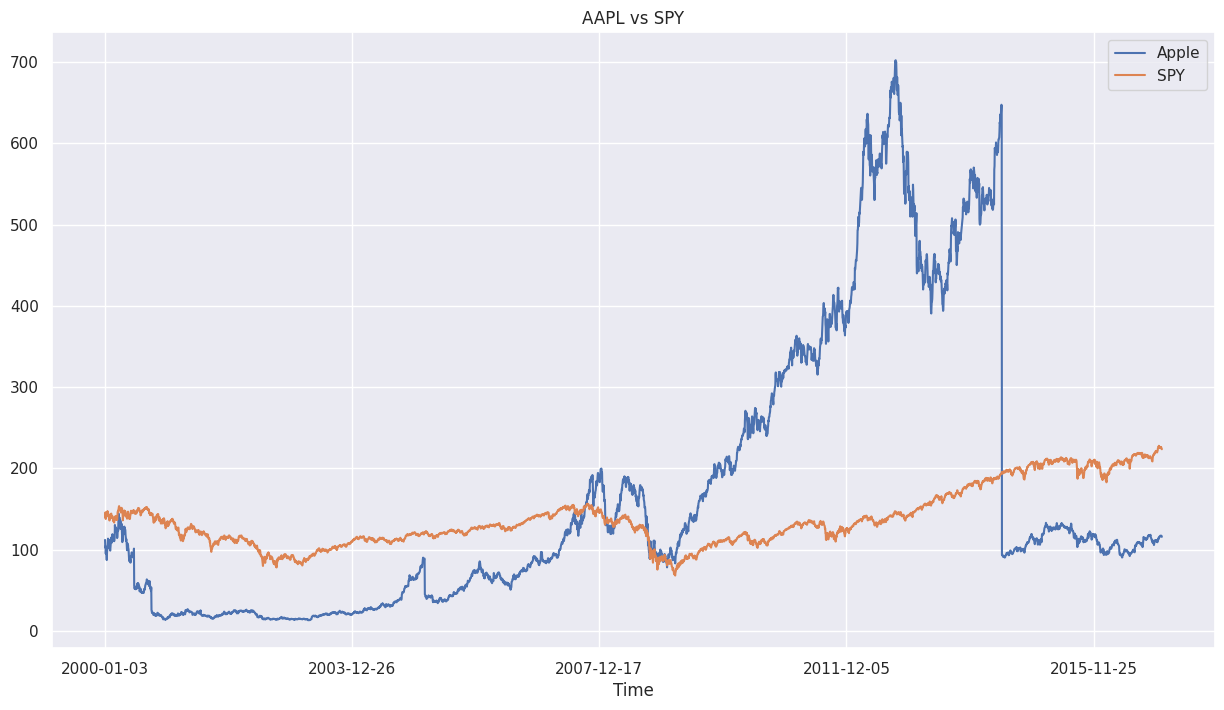

In [5]:
sns.set()
apple = data_train.loc[:,['Close','Adj Close']]
apple['lag1'] = apple['Close'].shift(periods = 1)
apple['returns'] = (apple['Close'] - apple['lag1']) / apple['lag1'] * 100
spy = index_data_train.loc[:,['Close','Adj Close']]
spy['lag1'] = spy['Close'].shift(periods = 1)
spy['returns'] = (spy['Close'] - spy['lag1']) / spy['lag1'] * 100
plt.figure(figsize=(15, 8))
apple['Close'].plot(label = 'Apple')
spy['Close'].plot(label = 'SPY')
plt.title('AAPL vs SPY')
plt.xlabel('Time')
plt.legend()

From the looks of AAPL price vs SPY price, it is not obviously evident that there might be some relation between SPY and AAPL returns, hence needs further analysis.

<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='Dt'>

<Axes: xlabel='Dt'>

Text(0.5, 1.0, 'AAPL vs SPY returns')

Text(0.5, 0, 'Time')

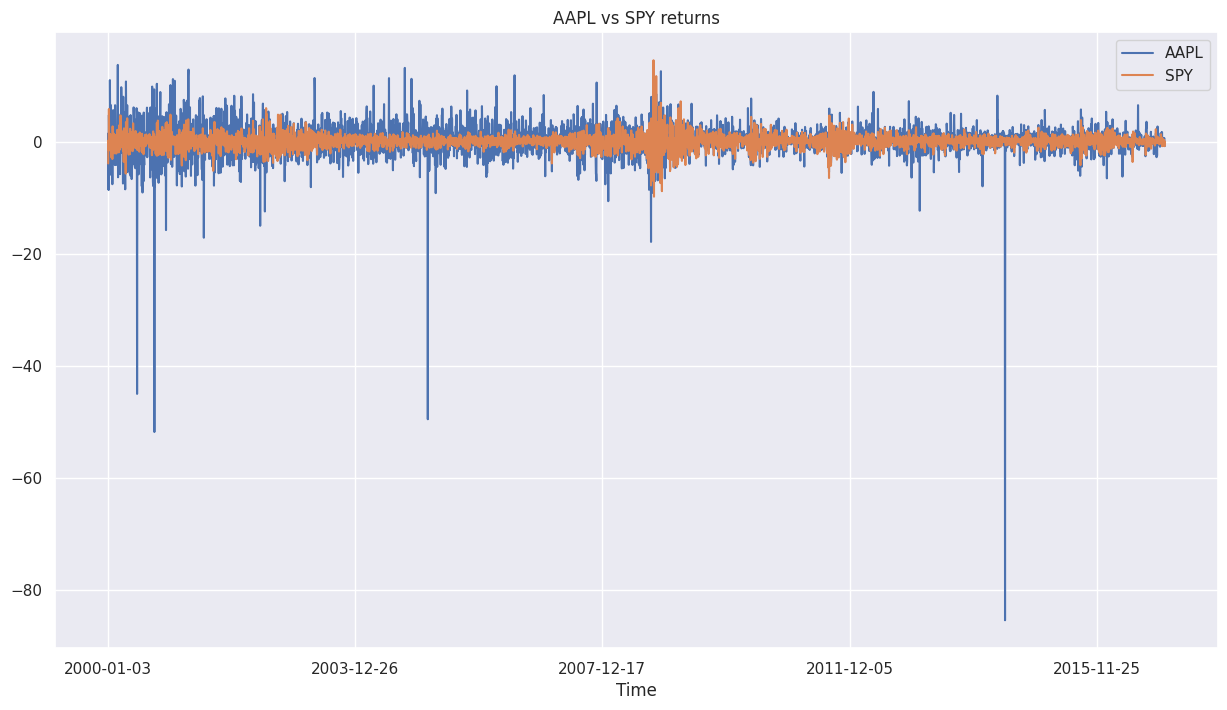

In [6]:
plt.figure(figsize=(15, 8))
apple['returns'].plot(label = 'AAPL')
spy['returns'].plot(label = 'SPY')
plt.title('AAPL vs SPY returns')
plt.xlabel('Time')
plt.legend()

From the AAPL vs SPY returns analysis above, the returns seems to have some correlation, hence I have decided to include SPY Close price and SPY percentage returns in the feature space to predict AAPL returns.

<Figure size 1500x800 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-85.48569481, -85.46581668, -85.44593855, ...,  13.86520242,
         13.88508055,  13.90495868]),
 <BarContainer object of 5000 artists>)

(-10.0, 10.0)

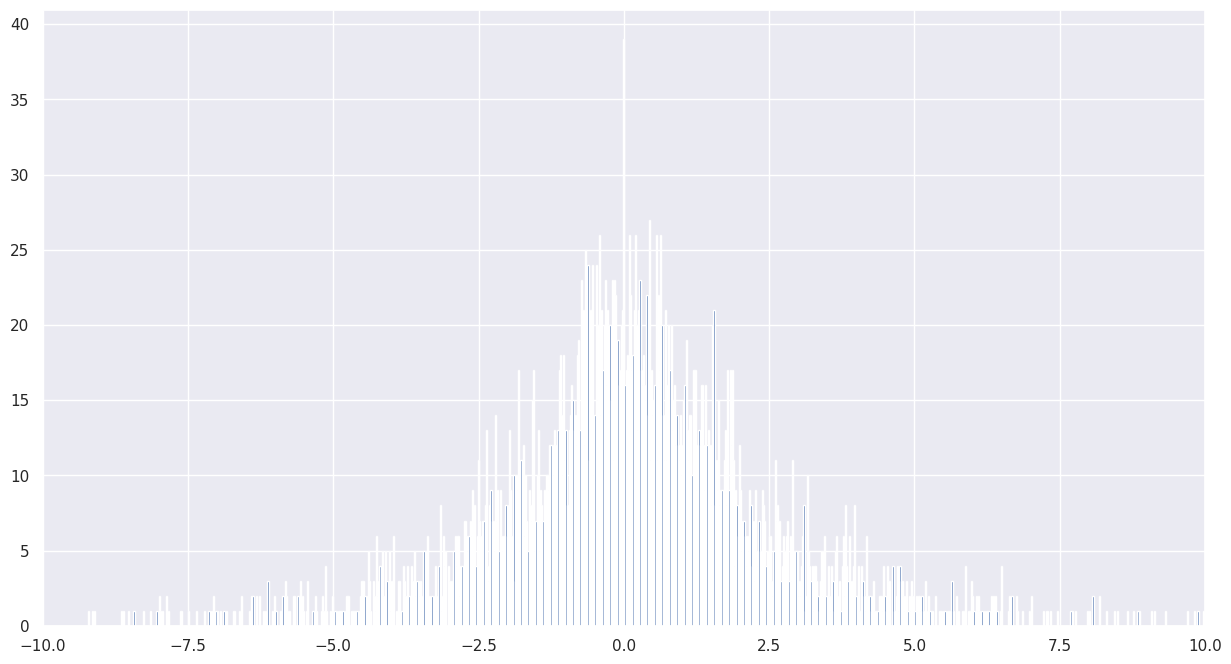

In [7]:
plt.figure(figsize=(15,8))
plt.hist(apple['returns'],bins = 5000)
plt.xlim([-10, 10])
plt.show()

<Figure size 1500x800 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-9.84476715, -9.83989424, -9.83502133, ..., 14.51002819,
        14.5149011 , 14.51977401]),
 <BarContainer object of 5000 artists>)

(-10.0, 10.0)

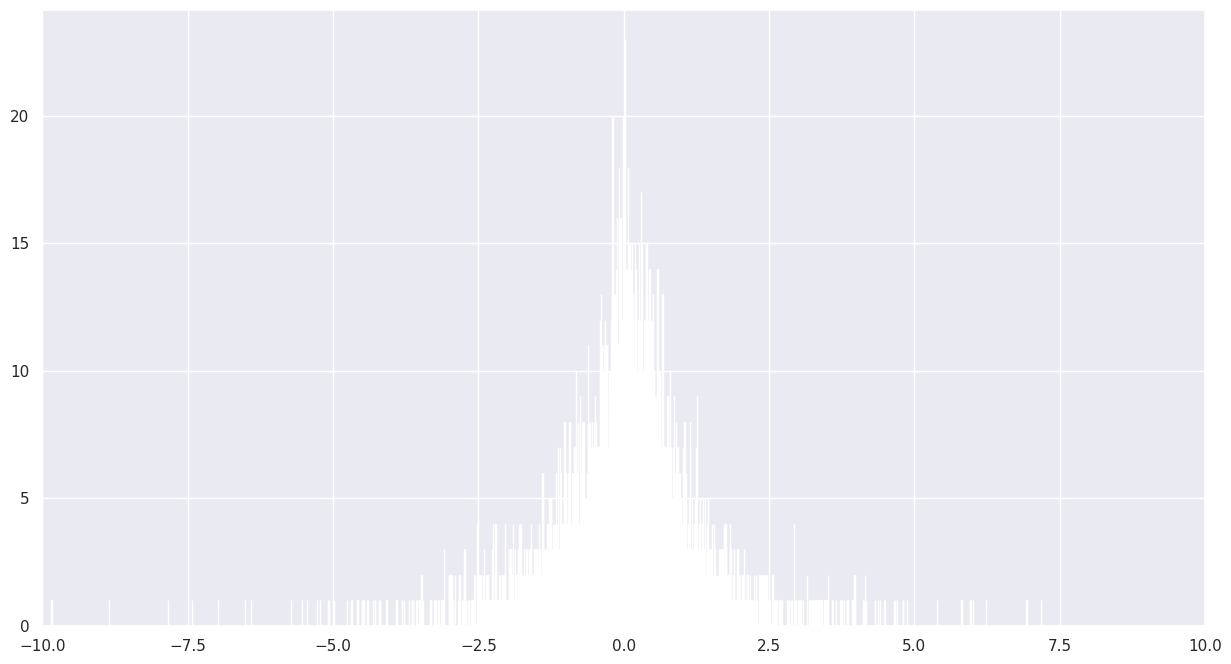

In [8]:
plt.figure(figsize=(15,8))
plt.hist(spy['returns'],bins = 5000)
plt.xlim([-10, 10])
plt.show()

**Both the returns seems approximately normally distributed, hence we continue our analysis!**

<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='Dt'>

<Axes: xlabel='Dt'>

Text(0.5, 1.0, 'AAPL vs SPY Adjusted Close')

Text(0.5, 0, 'Time')

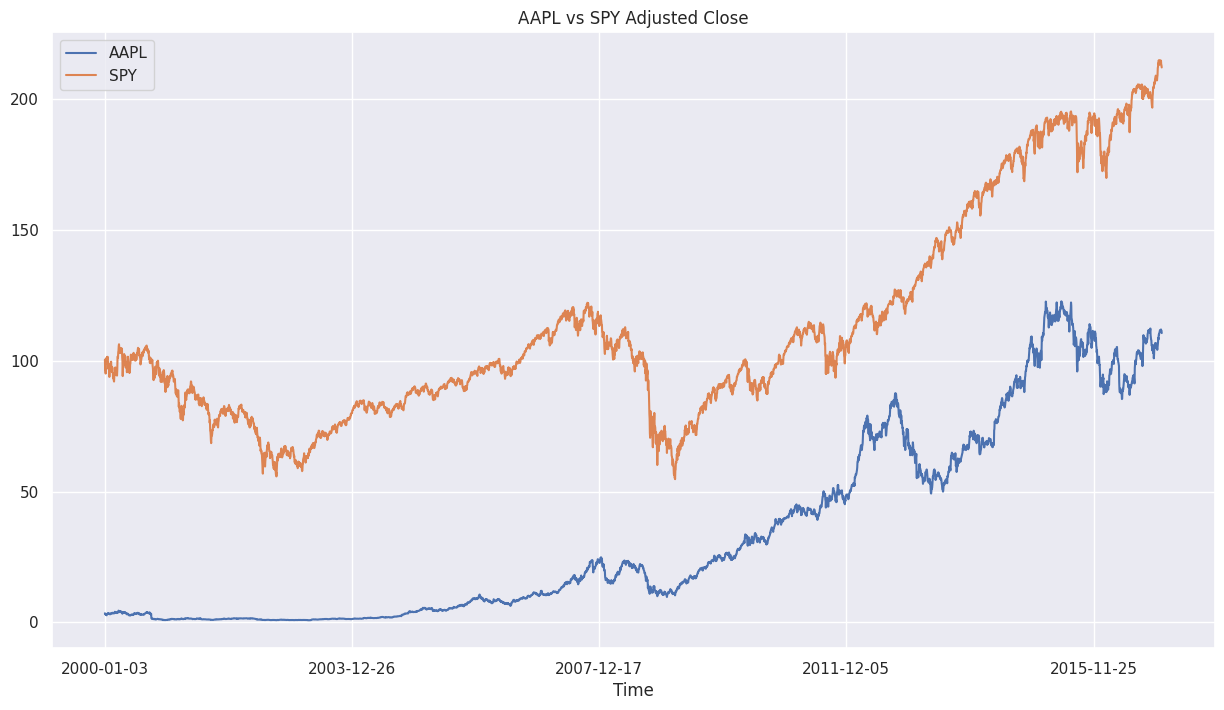

In [9]:
plt.figure(figsize=(15, 8))
apple['Adj Close'].plot(label = 'AAPL')
spy['Adj Close'].plot(label = 'SPY')
plt.title('AAPL vs SPY Adjusted Close')
plt.xlabel('Time')
plt.legend()

## Data Preprocessing

In [10]:
def Preprocess(data,idx):
  if(data.isna().any().any()):
    data.dropna(inplace = True)
  sma_5 = 5
  sma_30 = 30
  sma_45 = 45
  sma_60 = 60
  data['lag1'] = data['Close'].shift(periods = 1)
  data['lag2'] = data['Close'].shift(periods = 2)
  data['lag3'] = data['Close'].shift(periods = 3)
  data['lag4'] = data['Close'].shift(periods = 4)
  data['returns'] = (data['Close'] - data['lag1']) / data['lag1'] * 100
  data['Lagged Returns1'] = data['returns'].shift(periods = 1)
  data['Lagged Returns2'] = data['returns'].shift(periods = 2)
  data['Lagged Returns3'] = data['returns'].shift(periods = 3)
  data['Lagged Returns4'] = data['returns'].shift(periods = 4)
  data['Lagged Returns5'] = data['returns'].shift(periods = 5)
  data['sma_5'] = data['Close'].rolling(sma_5).mean()
  data['sma_30'] = data['Close'].rolling(sma_30).mean()
  data['sma_45'] = data['Close'].rolling(sma_45).mean()
  data['sma_60'] = data['Close'].rolling(sma_60).mean()
  data['SPY Close'] = idx['Close']
  data['SPY returns'] = data['SPY Close'].pct_change(1)* 100
  data.dropna(inplace = True)
  return data

As mentioned in the problem statement, I have calculated returns considering Close prices over adjusted close price. I have calculated lag1 through lag 4 and decided to include in the feature space because, I found that the contribution of lag 5 and above contributed minimally towards the target variable prediction and were seen as noise. The Preprocess function takes in AAPL and SPY data and calculates the necessary feature space for the prediction. I tried many combinations and found the above ones as apt for the problem.

In [11]:
data2 = Preprocess(data_train, index_data_train)
data2

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,lag1,lag2,...,Lagged Returns2,Lagged Returns3,Lagged Returns4,Lagged Returns5,sma_5,sma_30,sma_45,sma_60,SPY Close,SPY returns
Dt,,,,,,,,,,,,,,,,,,,,,
2000-03-28,4.3233,139.125,0.0,1.0,142.0000,137.125,137.2500,50741600.0,139.563,138.688,...,-1.857579,-1.993925,6.855000,9.705691,140.5754,123.361100,118.414400,114.300433,151.063,-0.575893
2000-03-29,4.2243,135.938,0.0,1.0,139.4380,133.828,139.3750,59959200.0,139.125,139.563,...,0.630913,-1.857579,-1.993925,6.855000,138.9254,123.925700,118.940800,114.700433,151.219,0.103268
2000-03-30,3.9077,125.750,0.0,1.0,137.6880,125.438,133.5630,103600000.0,135.938,139.125,...,-0.313837,0.630913,-1.857579,-1.993925,135.8128,124.313200,119.286622,115.087933,148.688,-1.673731
2000-03-31,4.2204,135.813,0.0,1.0,137.2500,126.000,127.4380,101158400.0,125.750,135.938,...,-2.290746,-0.313837,0.630913,-1.857579,135.2378,125.011133,119.860244,115.618150,150.375,1.134591
2000-04-03,4.1427,133.313,0.0,1.0,139.5000,129.438,135.5000,82140800.0,135.813,125.750,...,-7.494593,-2.290746,-0.313837,0.630913,133.9878,125.746567,120.564422,116.256700,151.250,0.581879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0,116.290,117.060,...,0.094057,0.265775,0.577736,0.129511,116.6920,112.194333,112.390000,113.177000,225.710,0.146419
2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0,116.520,116.290,...,-0.657782,0.094057,0.265775,0.577736,116.8160,112.488667,112.404667,113.247167,226.270,0.248106
2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0,117.260,116.520,...,0.197781,-0.657782,0.094057,0.265775,116.7780,112.857000,112.384889,113.317833,224.400,-0.826446


In [12]:
data2.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,lag1,lag2,...,Lagged Returns2,Lagged Returns3,Lagged Returns4,Lagged Returns5,sma_5,sma_30,sma_45,sma_60,SPY Close,SPY returns
count,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4.218000e+03,4218.000000,4218.000000,...,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000
mean,34.492848,171.241646,0.002027,1.001897,173.192833,169.220286,171.327151,1.301652e+08,171.247275,171.252481,...,0.065537,0.065166,0.066640,0.068894,171.252878,171.282525,171.290627,171.286579,137.743459,0.016908
std,36.775486,174.558176,0.031226,0.094908,176.082309,172.989798,174.677556,1.001002e+08,174.556771,174.555472,...,3.121343,3.121495,3.123233,3.126757,174.341592,173.273327,172.664273,172.083406,36.316589,1.245921
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,13.120000,13.120000,...,-85.485695,-85.485695,-85.485695,-85.485695,13.280000,14.038667,14.250667,14.352833,68.110000,-9.844767
25%,3.017200,38.320000,0.000000,1.000000,38.862500,37.834850,38.395000,6.318795e+07,38.320000,38.320000,...,-1.121799,-1.122943,-1.122943,-1.122943,38.436000,38.864583,39.292828,39.464329,112.860000,-0.531246
50%,17.418800,105.995000,0.000000,1.000000,107.615000,104.885000,106.305000,1.015721e+08,105.995000,105.995000,...,0.071190,0.071190,0.071190,0.071190,106.455100,106.547133,106.503978,107.282542,129.165000,0.055700
75%,63.024850,234.347500,0.000000,1.000000,235.925000,228.290150,232.955000,1.685745e+08,234.347500,234.347500,...,1.358551,1.358551,1.360252,1.361026,235.159500,243.068800,244.535978,243.345071,151.273250,0.589369
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09,702.100000,702.100000,...,13.904959,13.904959,13.904959,13.904959,700.517200,676.324567,665.540889,654.244950,227.760000,14.519774


<Figure size 1500x800 with 0 Axes>

<Axes: >

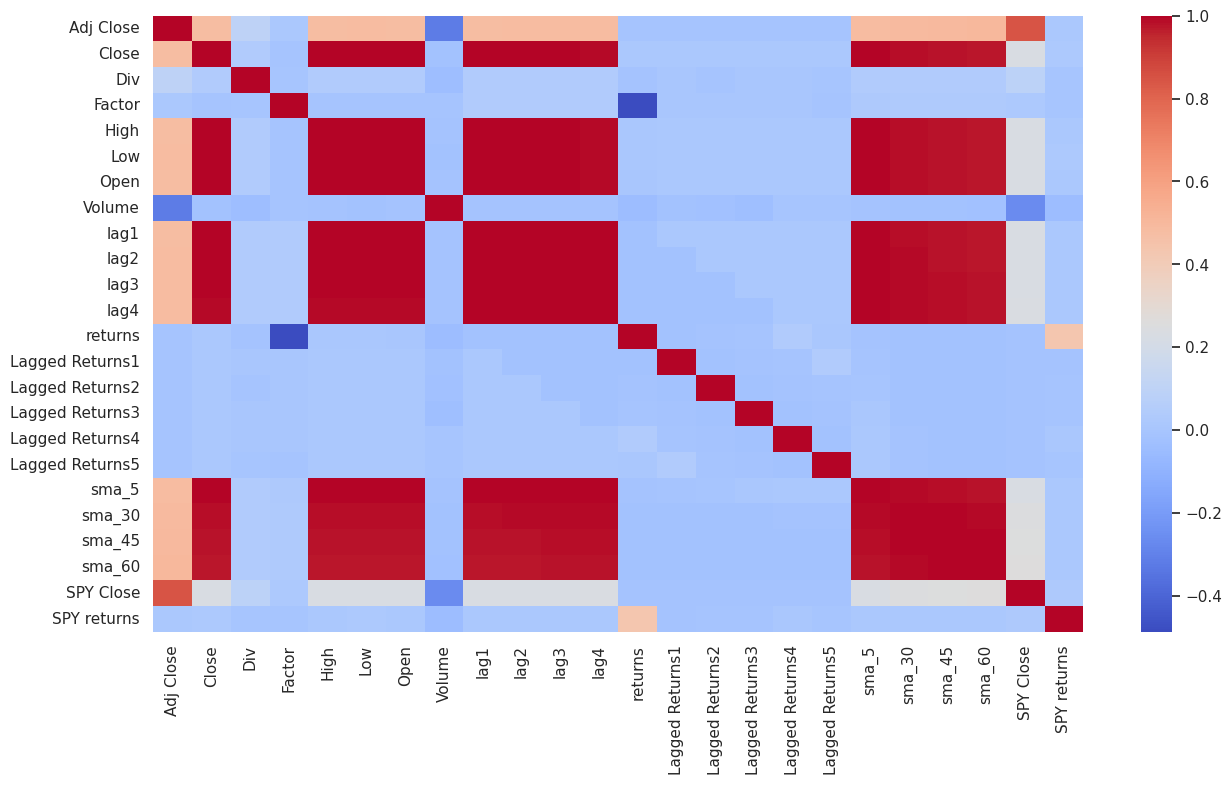

In [13]:
correlated_matrix = data2.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlated_matrix, cmap='coolwarm')
plt.show()

The above heatmap shows the correlation of feature space with itself and with the returns column. Note the above relationship is on unscaled data.

## Functions

In [14]:
def train_test_split(df):
  tss = TimeSeriesSplit(n_splits = 5)
  X = df.drop(labels = ['returns'], axis = 1)
  y = df['returns']
  for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  return X_train, y_train, X_test, y_test

I have used TimeSeriesSplit by sklearn to split the data because a train test split will split the data randomly and for time series anlysis, it won't be ideal. 

In [15]:
def Normalization(df):
  window_size = 30

  # Create a scaler object
  scaler = StandardScaler()

  # Iterate through the time series data and apply window scaling
  for i in range(df.shape[0]):
      # Determine the start and end of the window
      start_index = max(0, i - window_size)
      end_index = min(i + 1, df.shape[0])
      
      # Extract the window of data
      window = df[start_index:end_index]
      
      # Fit the scaler to the window of data
      scaler.fit(window)
      
      # Transform the current observation using the scaler
      current_observation = df[i:i+1]
      scaled_observation = scaler.transform(current_observation)
      
      # Update the dataframe with the scaled observation
      df[i:i+1] = scaled_observation
  return df, scaler

To avoid potential look-ahead bias and account for inflation and time value, I used window scaling to scale the data over a 30-day period. Although the period can be adjusted depending on the specific use case, I found that a 30-day period yielded better results. I chose to use Standard Scaling over min-max scaling for several reasons, including its robustness to outliers, ability to preserve the distribution shape, and superior performance for neural networks that consider distance.

In [16]:
def Normalization_Split_train(df, df1):
  data_preprocessed = Preprocess(df, df1)
  X_train_processed, y_train_processed, X_validate_processed, y_validate_processed = train_test_split(data_preprocessed)
 
  #scaler = StandardScaler()
 
  X_train_processed, scaler_xtrain = Normalization(X_train_processed.to_numpy())
  y_train_processed, scaler_ytrain = Normalization(y_train_processed.to_numpy().reshape(-1,1))
  
  X_validate_processed, scaler_xval = Normalization(X_validate_processed.to_numpy())
  y_validate_processed, scaler_yval = Normalization(y_validate_processed.to_numpy().reshape(-1,1))
  return X_train_processed, y_train_processed, X_validate_processed, y_validate_processed, scaler_xtrain, scaler_ytrain, scaler_xval, scaler_yval

I have split the data into train and validation with n_split = 5 under TimeSeriesSplit and then applied scaling in order to avoid look ahead bias. Additionally, seperated returns as the y variable or the variable we want the neural networks to learn.

In [17]:
def Normalization_Split_test(df, df1):
  data_preprocessed = Preprocess(df, df1)
  X_test_processed, y_test_processed = data_preprocessed.drop(labels = ['returns'], axis = 1), data_preprocessed['returns']
  X_test_processed, scaler_xtest = Normalization(X_test_processed.to_numpy())
  y_test_processed, scaler_ytest = Normalization(y_test_processed.to_numpy().reshape(-1,1))
  return X_test_processed, y_test_processed, scaler_xtest, scaler_ytest

In [18]:
def plot(y_validate_processed, predicted_stock_price):
  plt.figure(figsize=(15, 10))
  plt.plot(y_validate_processed, color = 'red', label = 'Actual returns')
  plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted returns')
  plt.title('Apple Stock Price Predictor')
  plt.xlabel('Time')
  plt.ylabel('Apple Stock Price')
  plt.legend()

plot function plots the graph between actual returns and predicted returns for all the models. This is part of error analysis to analysis the performance of the model in consideration.

In [19]:
X_train_processed, y_train_processed, X_validate_processed, y_validate_processed, scaler_xtrain, scaler_ytrain, scaler_xval, scaler_yval = Normalization_Split_train(data_train, index_data_train)

In [20]:
X_test_processed, y_test_processed, scaler_xtest, scaler_ytest = Normalization_Split_test(data_validate, index_data_validate)

## Feature Importance

<ipython-input-21-62e3f05638d1>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


RandomForestRegressor()

Adj Close: 0.0695
Close: 0.0007
Div: 0.0205
Factor: 0.0420
High: 0.0007
Low: 0.0008
Open: 0.0006
Volume: 0.0002
lag1: 0.0007
lag2: 0.0007
lag3: 0.0006
lag4: 0.0004
Lagged Returns1: 0.0985
Lagged Returns2: 0.0950
Lagged Returns3: 0.0905
Lagged Returns4: 0.0924
Lagged Returns5: 0.0889
sma_5: 0.0006
sma_30: 0.0008
sma_45: 0.0006
sma_60: 0.0005
SPY Close: 0.0003
SPY returns: 0.3947


<BarContainer object of 23 artists>

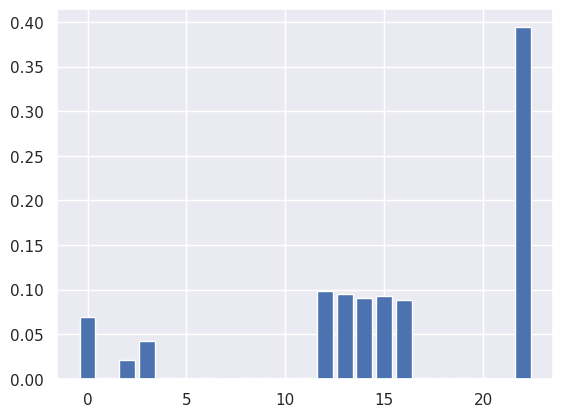

In [21]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define dataset
X, y = X_train_processed, y_train_processed
model = RandomForestRegressor()
model.fit(X, y)
# get importance
importances = model.feature_importances_
feature_names = data_train.drop(labels=['returns'], axis=1).columns
for name, importance in zip(feature_names, importances):
    print(f'{name}: {importance:.4f}')
# plot feature importance
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

Random Forest regressor, where the importance of a feature is measured by how much it reduces the impurity or variance in the decision tree when that feature is used to split the data is used to find feature importance. It measures both linear and non-linear relationship between features and the target variable. As can be seen Adjusted Close price, Lag-1 to Lag-5 and SPY returns contribute/have higher feature variable importance compared to others.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Adj Close: 0.0108
Close: 0.0000
Div: 0.0095
Factor: 0.0073
High: 0.0000
Low: 0.0000
Open: 0.0000
Volume: 0.0000
lag1: 0.0000
lag2: 0.0000
lag3: 0.0000
lag4: 0.0000
Lagged Returns1: 0.0027
Lagged Returns2: 0.0166
Lagged Returns3: 0.0189
Lagged Returns4: 0.0234
Lagged Returns5: 0.0000
sma_5: 0.0000
sma_30: 0.0000
sma_45: 0.0000
sma_60: 0.0000
SPY Close: 0.0000
SPY returns: 0.2103


<BarContainer object of 23 artists>

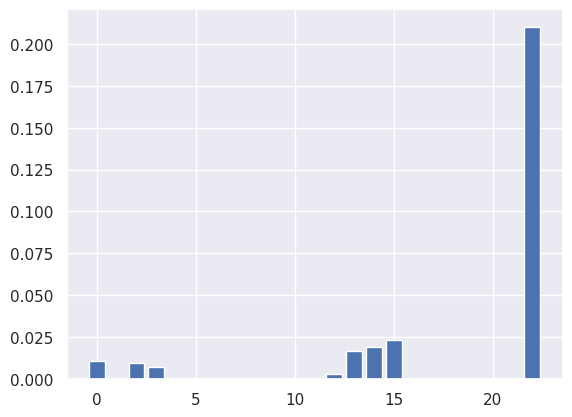

In [22]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X, y)
feature_names = data_train.drop(labels=['returns'], axis=1).columns
# Print the feature importance scores
for name, score in zip(feature_names,mi_scores):
    print(f'{name}: {score:.4f}')

# plot feature importance
pyplot.bar([x for x in range(len(mi_scores))], mi_scores)
pyplot.show()

Mutual information measures the dependence between the feature and the target variable, which may not always align with the effect of the feature on the variance or impurity in the decision tree. This method tends to favor features that have a strong relationship with the target variable, even if the relationship is not direct or linear. SPY returns in both the methods have highest importance. 

## Models

## LSTM Model

In [23]:
model0 = None
units = 300
from keras.regularizers import l1, l2
model0 = tf.keras.Sequential()
model0.add(LSTM(units = units, return_sequences = True, input_shape = (X_train_processed.shape[1], 1)))
model0.add(Dropout(0.2))
model0.add(LSTM(units = units, return_sequences = True))
model0.add(Dropout(0.2))
model0.add(LSTM(units = units, return_sequences = True))
model0.add(Dropout(0.2))
model0.add(LSTM(units = units, return_sequences = True))
model0.add(Dropout(0.2))
model0.add(LSTM(units = units))
model0.add(Dropout(0.2))
model0.add(Dense(units=1))
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 23, 300)           362400    
                                                                 
 dropout (Dropout)           (None, 23, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 23, 300)           721200    
                                                                 
 dropout_1 (Dropout)         (None, 23, 300)           0         
                                                                 
 lstm_2 (LSTM)               (None, 23, 300)           721200    
                                                                 
 dropout_2 (Dropout)         (None, 23, 300)           0         
                                                                 
 lstm_3 (LSTM)               (None, 23, 300)           7

I have tried various architectures for LSTM model and decided that the above architecture worked the best for the problem. I have used mean_squared_error as the loss function and adam optimizer as they are suited well for time series regression task. I have used dropout layer in order to avoid overfitting of the data.

Epoch 1/200
109/109 [==============================] - ETA: 0s - loss: 2.1680 - mean_squared_error: 2.1680

109/109 [==============================] - 35s 221ms/step - loss: 2.1680 - mean_squared_error: 2.1680 - val_loss: 1.3814 - val_mean_squared_error: 1.3814
Epoch 2/200
106/109 [============================>.] - ETA: 0s - loss: 2.1521 - mean_squared_error: 2.1521

109/109 [==============================] - 25s 227ms/step - loss: 2.1485 - mean_squared_error: 2.1485 - val_loss: 1.3793 - val_mean_squared_error: 1.3793
Epoch 3/200
109/109 [==============================] - 2s 17ms/step - loss: 2.1459 - mean_squared_error: 2.1459 - val_loss: 1.3870 - val_mean_squared_error: 1.3870
Epoch 4/200
109/109 [==============================] - 2s 15ms/step - loss: 2.1493 - mean_squared_error: 2.1493 - val_loss: 1.3795 - val_mean_squared_error: 1.3795
Epoch 5/200
109/109 [==============================] - 2s 15ms/step - loss: 2.1464 - mean_squared_error: 2.1464 - val_loss: 1.3819 - val_mean_squared_error: 1.3819
Epoch 6/200
109/109 [==============================] - 2s 15ms/step - loss: 2.1449 - mean_squared_error: 2.1449 - val_loss: 1.3793 - val_mean_squared_error: 1.3793
Epoch 7/200
109/109 [==============================] - ETA: 0s - loss: 2.1430 - mean_squared_error: 2.1430

109/109 [==============================] - 22s 201ms/step - loss: 2.1430 - mean_squared_error: 2.1430 - val_loss: 1.3792 - val_mean_squared_error: 1.3792
Epoch 8/200
109/109 [==============================] - 2s 16ms/step - loss: 2.1464 - mean_squared_error: 2.1464 - val_loss: 1.4061 - val_mean_squared_error: 1.4061
Epoch 9/200
109/109 [==============================] - ETA: 0s - loss: 2.1453 - mean_squared_error: 2.1453

109/109 [==============================] - 21s 190ms/step - loss: 2.1453 - mean_squared_error: 2.1453 - val_loss: 1.3791 - val_mean_squared_error: 1.3791
Epoch 10/200
108/109 [============================>.] - ETA: 0s - loss: 2.1365 - mean_squared_error: 2.1365

109/109 [==============================] - 22s 205ms/step - loss: 2.1437 - mean_squared_error: 2.1437 - val_loss: 1.3789 - val_mean_squared_error: 1.3789
Epoch 11/200
109/109 [==============================] - ETA: 0s - loss: 2.1419 - mean_squared_error: 2.1419

109/109 [==============================] - 22s 200ms/step - loss: 2.1419 - mean_squared_error: 2.1419 - val_loss: 1.3783 - val_mean_squared_error: 1.3783
Epoch 12/200
109/109 [==============================] - 2s 18ms/step - loss: 2.2264 - mean_squared_error: 2.2264 - val_loss: 1.4623 - val_mean_squared_error: 1.4623
Epoch 13/200
109/109 [==============================] - ETA: 0s - loss: 2.1665 - mean_squared_error: 2.1665

109/109 [==============================] - 21s 194ms/step - loss: 2.1665 - mean_squared_error: 2.1665 - val_loss: 1.3721 - val_mean_squared_error: 1.3721
Epoch 14/200
109/109 [==============================] - ETA: 0s - loss: 2.0846 - mean_squared_error: 2.0846

109/109 [==============================] - 22s 200ms/step - loss: 2.0846 - mean_squared_error: 2.0846 - val_loss: 1.0405 - val_mean_squared_error: 1.0405
Epoch 15/200
107/109 [============================>.] - ETA: 0s - loss: 1.7867 - mean_squared_error: 1.7867

109/109 [==============================] - 21s 198ms/step - loss: 1.7792 - mean_squared_error: 1.7792 - val_loss: 0.9732 - val_mean_squared_error: 0.9732
Epoch 16/200
108/109 [============================>.] - ETA: 0s - loss: 1.6646 - mean_squared_error: 1.6646

109/109 [==============================] - 21s 198ms/step - loss: 1.6632 - mean_squared_error: 1.6632 - val_loss: 0.9387 - val_mean_squared_error: 0.9387
Epoch 17/200
109/109 [==============================] - 2s 16ms/step - loss: 1.6424 - mean_squared_error: 1.6424 - val_loss: 0.9424 - val_mean_squared_error: 0.9424
Epoch 18/200
109/109 [==============================] - ETA: 0s - loss: 1.6210 - mean_squared_error: 1.6210

109/109 [==============================] - 22s 203ms/step - loss: 1.6210 - mean_squared_error: 1.6210 - val_loss: 0.9276 - val_mean_squared_error: 0.9276
Epoch 19/200
108/109 [============================>.] - ETA: 0s - loss: 1.5981 - mean_squared_error: 1.5981

109/109 [==============================] - 21s 190ms/step - loss: 1.5977 - mean_squared_error: 1.5977 - val_loss: 0.9200 - val_mean_squared_error: 0.9200
Epoch 20/200
109/109 [==============================] - 2s 15ms/step - loss: 1.6078 - mean_squared_error: 1.6078 - val_loss: 0.9620 - val_mean_squared_error: 0.9620
Epoch 21/200
109/109 [==============================] - 2s 21ms/step - loss: 1.6061 - mean_squared_error: 1.6061 - val_loss: 0.9240 - val_mean_squared_error: 0.9240
Epoch 22/200
109/109 [==============================] - ETA: 0s - loss: 1.5872 - mean_squared_error: 1.5872

109/109 [==============================] - 21s 196ms/step - loss: 1.5872 - mean_squared_error: 1.5872 - val_loss: 0.9150 - val_mean_squared_error: 0.9150
Epoch 23/200
109/109 [==============================] - 2s 16ms/step - loss: 1.5843 - mean_squared_error: 1.5843 - val_loss: 0.9304 - val_mean_squared_error: 0.9304
Epoch 24/200
109/109 [==============================] - 2s 15ms/step - loss: 1.5906 - mean_squared_error: 1.5906 - val_loss: 0.9270 - val_mean_squared_error: 0.9270
Epoch 25/200
109/109 [==============================] - 2s 19ms/step - loss: 1.5811 - mean_squared_error: 1.5811 - val_loss: 0.9245 - val_mean_squared_error: 0.9245
Epoch 26/200
107/109 [============================>.] - ETA: 0s - loss: 1.5445 - mean_squared_error: 1.5445

109/109 [==============================] - 21s 197ms/step - loss: 1.5687 - mean_squared_error: 1.5687 - val_loss: 0.9058 - val_mean_squared_error: 0.9058
Epoch 27/200
109/109 [==============================] - 2s 16ms/step - loss: 1.5819 - mean_squared_error: 1.5819 - val_loss: 0.9203 - val_mean_squared_error: 0.9203
Epoch 28/200
109/109 [==============================] - 2s 16ms/step - loss: 1.5869 - mean_squared_error: 1.5869 - val_loss: 0.9080 - val_mean_squared_error: 0.9080
Epoch 29/200
109/109 [==============================] - ETA: 0s - loss: 1.5827 - mean_squared_error: 1.5827

109/109 [==============================] - 22s 201ms/step - loss: 1.5827 - mean_squared_error: 1.5827 - val_loss: 0.9050 - val_mean_squared_error: 0.9050
Epoch 30/200
109/109 [==============================] - 2s 16ms/step - loss: 1.5895 - mean_squared_error: 1.5895 - val_loss: 0.9160 - val_mean_squared_error: 0.9160
Epoch 31/200
109/109 [==============================] - 2s 15ms/step - loss: 1.5830 - mean_squared_error: 1.5830 - val_loss: 0.9284 - val_mean_squared_error: 0.9284
Epoch 32/200
109/109 [==============================] - 2s 15ms/step - loss: 1.5633 - mean_squared_error: 1.5633 - val_loss: 0.9336 - val_mean_squared_error: 0.9336
Epoch 33/200
109/109 [==============================] - 2s 16ms/step - loss: 1.5522 - mean_squared_error: 1.5522 - val_loss: 0.9389 - val_mean_squared_error: 0.9389
Epoch 34/200
109/109 [==============================] - 2s 21ms/step - loss: 1.5683 - mean_squared_error: 1.5683 - val_loss: 0.9288 - val_mean_squared_error: 0.9288
Epoch 35/200
109/109 

<Figure size 1500x800 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

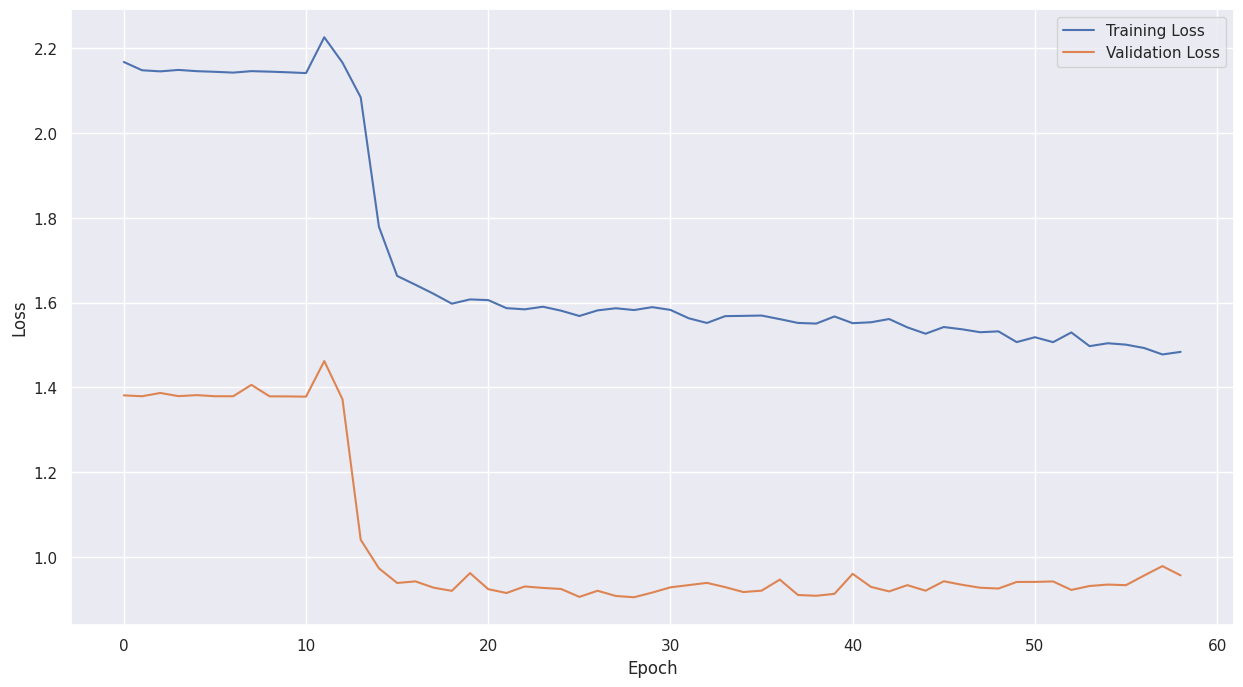

In [24]:
model_name0 = "LSTM"
loss = "mean_squared_error"
optimizer = "adam"
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True)
callbacks =  ModelCheckpoint(filepath=model_name0 + ".ckpt", monitor='val_mean_squared_error', save_best_only=True)
model0.compile(optimizer = optimizer, loss = loss, metrics=[loss])
history = model0.fit(X_train_processed, y_train_processed, validation_data=(X_validate_processed, y_validate_processed), epochs=200, batch_size=32, callbacks = [es, callbacks])
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_mean_squared_error'], label='Validation Loss')
# Plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Validation period is strictly after the training period.

In [25]:
predicted_stock_price_LSTM_train = model0.predict(X_train_processed)
predicted_stock_price_LSTM_val = model0.predict(X_validate_processed)

22/22 [==============================] - 0s 5ms/step


In [26]:
predicted_stock_price_LSTM_test = model0.predict(X_test_processed)

6/6 [==============================] - 0s 5ms/step


In [27]:
y_train_processed_LSTM = scaler_ytrain.inverse_transform(y_train_processed)
y_validate_processed_LSTM = scaler_yval.inverse_transform(y_validate_processed)
y_test_processed_LSTM = scaler_ytest.inverse_transform(y_test_processed)
predicted_stock_price_LSTM_train = scaler_ytrain.inverse_transform(predicted_stock_price_LSTM_train)
predicted_stock_price_LSTM_val = scaler_yval.inverse_transform(predicted_stock_price_LSTM_val)
predicted_stock_price_LSTM_test = scaler_ytest.inverse_transform(predicted_stock_price_LSTM_test)

In [28]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history, model_name0)

Directory ./models/LSTM already exists, files will be over-written.
Model saved in directory ./models/LSTM; create an archive of this directory and submit with your assignment.
Directory ./models/LSTM already exists, files will be over-written.


## Error Analysis:

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Apple Stock Price Predictor')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Stock Price')

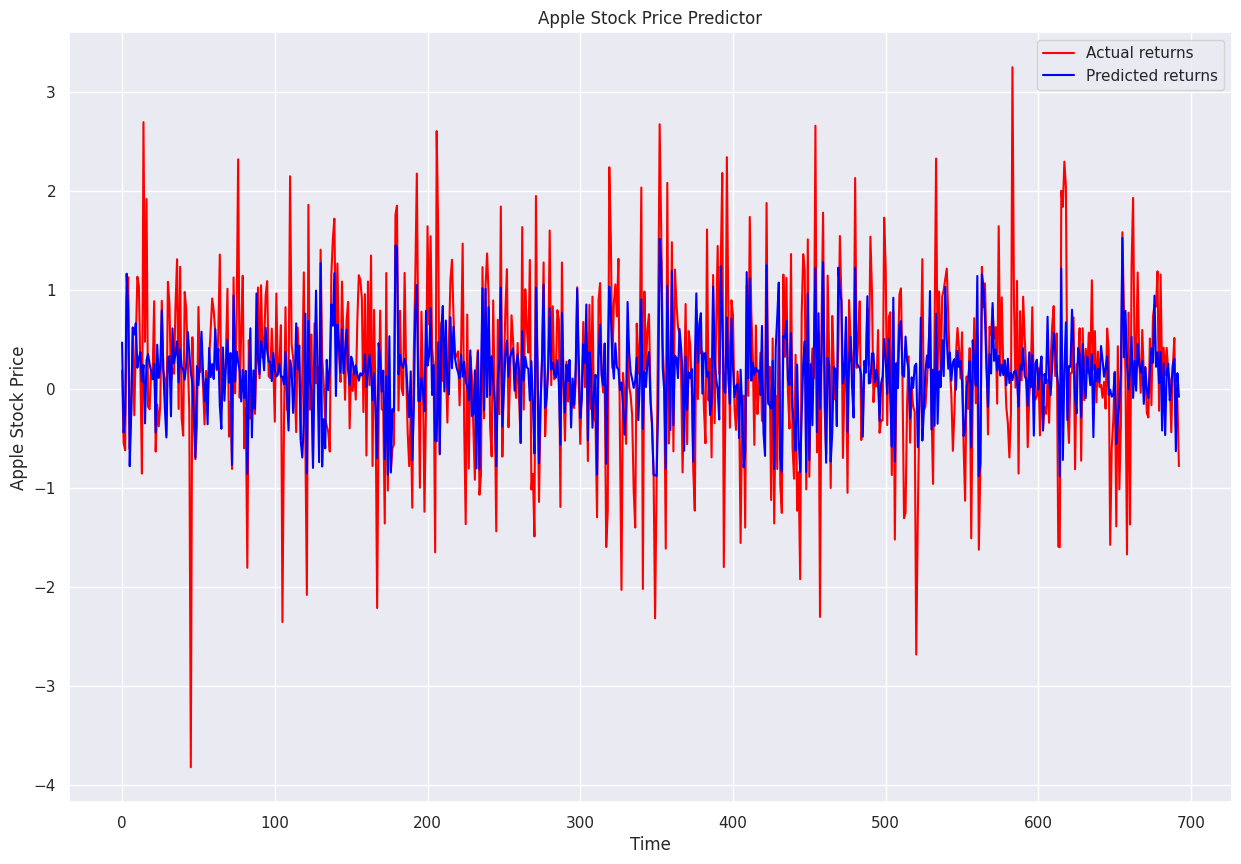

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(y_validate_processed_LSTM, color = 'red', label = 'Actual returns')
plt.plot(predicted_stock_price_LSTM_val, color = 'blue', label = 'Predicted returns')
plt.title('Apple Stock Price Predictor')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()

The graph above shows the actual vs predicted scaled returns on the validation data. The graph is a visual representation of goodness of fit of the model on unseen data.

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Apple Stock Price Predictor')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Stock Price')

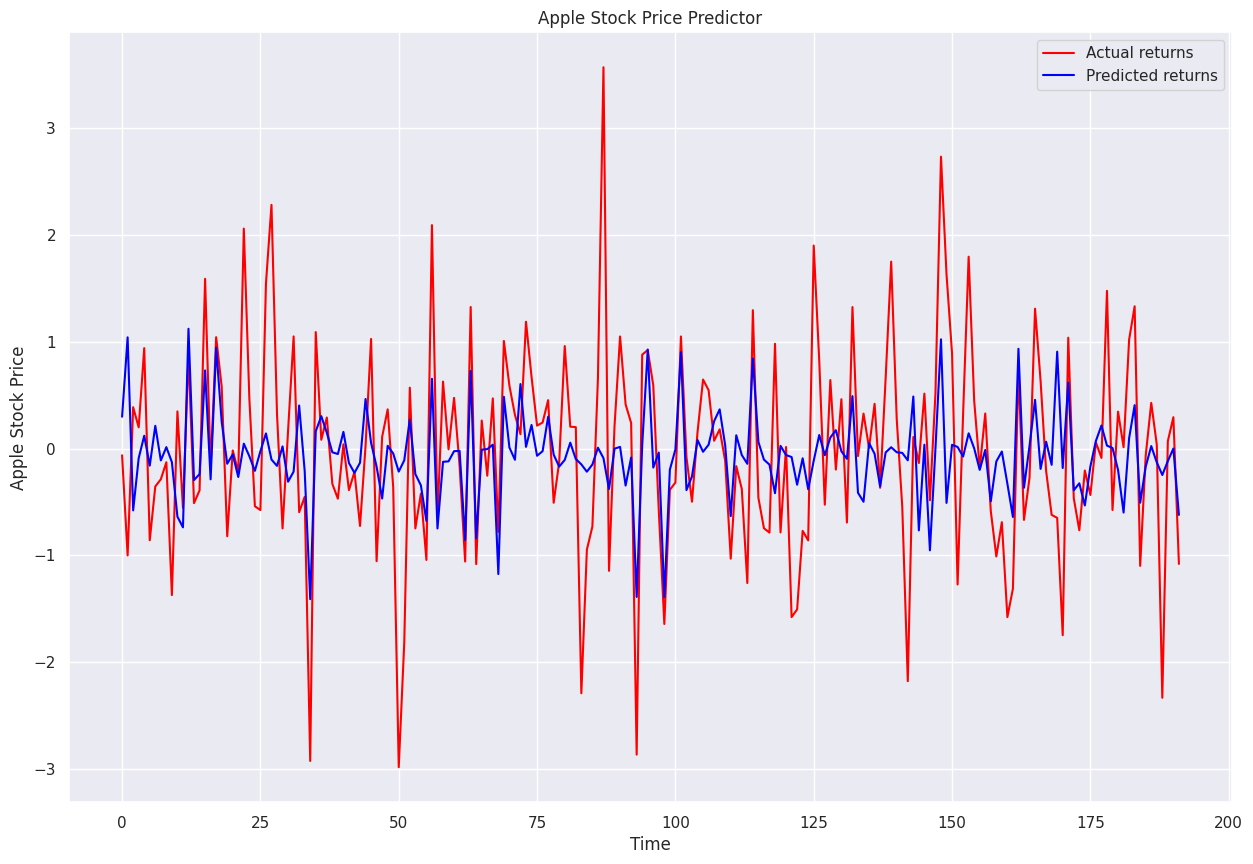

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_processed_LSTM, color = 'red', label = 'Actual returns')
plt.plot(predicted_stock_price_LSTM_test, color = 'blue', label = 'Predicted returns')
plt.title('Apple Stock Price Predictor')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()

The graph above is the graph on test data which I took from sample sub-directory of the Data directory. As this data is also strictly after the train and validation data, it shows goodness of fit of the trained model. 

In [31]:
mse = mean_squared_error(y_validate_processed_LSTM, predicted_stock_price_LSTM_val)
mae = mean_absolute_error(y_validate_processed_LSTM, predicted_stock_price_LSTM_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate_processed_LSTM, predicted_stock_price_LSTM_val)
mape = mean_absolute_percentage_error(y_validate_processed_LSTM, predicted_stock_price_LSTM_val)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.4862165290251759
Root Mean Squared Error (RMSE): 0.6972922837843367
Mean Absolute Error (MAE): 0.5079426436420382
R-squared (R2) score: 0.343978385191969
Mean Absolute Percentage Error (MAPE): 1.6739598332385277


In [32]:
mse = mean_squared_error(y_test_processed_LSTM, predicted_stock_price_LSTM_test)
mae = mean_absolute_error(y_test_processed_LSTM, predicted_stock_price_LSTM_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_processed_LSTM, predicted_stock_price_LSTM_test)
mape = mean_absolute_percentage_error(y_test_processed_LSTM, predicted_stock_price_LSTM_test)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.728616598549205
Root Mean Squared Error (RMSE): 0.8535904161535584
Mean Absolute Error (MAE): 0.6349848802326264
R-squared (R2) score: 0.2380662983345655
Mean Absolute Percentage Error (MAPE): 1.5678153836841953


As the problem is a regressing problem, mse score, mae score, rmse, r2 score are the main metrics to measure the performance of the model. I performed multiple experiments by changing values of hyperparameters and decided on the final model.

(array([  1.,   0.,   1.,   0.,   1.,   3.,  10.,  11.,  31.,  79., 168.,
        155., 124.,  65.,  22.,  13.,   4.,   1.,   2.,   2.]),
 array([-3.98899398, -3.63154042, -3.27408686, -2.9166333 , -2.55917975,
        -2.20172619, -1.84427263, -1.48681907, -1.12936552, -0.77191196,
        -0.4144584 , -0.05700484,  0.30044871,  0.65790227,  1.01535583,
         1.37280939,  1.73026294,  2.0877165 ,  2.44517006,  2.80262362,
         3.16007717]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'Residuals')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Residuals')

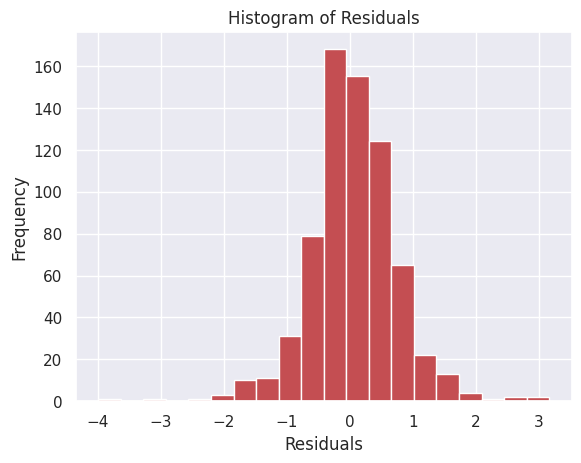

In [33]:
residuals = y_validate_processed_LSTM - predicted_stock_price_LSTM_val

# Plot a histogram of the residuals
plt.hist(residuals, color = 'r', bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In deep learning models, the residuals being approximately normal is important. This is because deep learning models, like other regression models, are based on the assumption that the error terms are normally distributed with a mean of zero and a constant variance (homoscedasticity). If this assumption is violated, it can lead to biased or inefficient estimates of the model parameters, and may impact the accuracy and reliability of the predictions. The residual distribution appears approximately normal indicating the model is adequately capturing the underlying patterns in the data.

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residuals vs. Predicted Values')

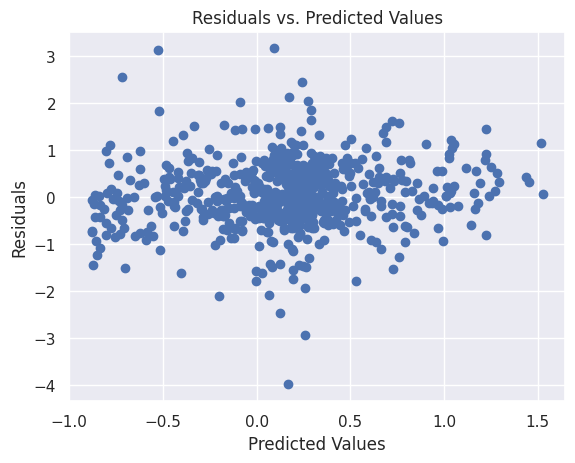

In [34]:
# Plot the residuals vs. the predicted values
plt.scatter(predicted_stock_price_LSTM_val, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

The above graph shows the outliers in the predictions which are less in number as compared to the correctly predicted values indicating the model is performing well. 

## ANN Model

In [35]:
model1 = None
model1 = tf.keras.Sequential()
units = 300

model1.add(Dense(units = units,kernel_regularizer=l2(0.01), input_shape = (X_train_processed.shape[1], 1), name = 'Dense_head', activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = units, name = 'Dense_1', activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = units, name = 'Dense_2', activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = units, name = 'Dense_3', activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=1, activation = 'linear', name = 'Output_layer'))
model1.add(Flatten())
model1.add(Dense(units=1, activation='linear', name='Final_output'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_head (Dense)          (None, 23, 300)           600       
                                                                 
 dropout_5 (Dropout)         (None, 23, 300)           0         
                                                                 
 Dense_1 (Dense)             (None, 23, 300)           90300     
                                                                 
 dropout_6 (Dropout)         (None, 23, 300)           0         
                                                                 
 Dense_2 (Dense)             (None, 23, 300)           90300     
                                                                 
 dropout_7 (Dropout)         (None, 23, 300)           0         
                                                                 
 Dense_3 (Dense)             (None, 23, 300)          

Epoch 1/200
109/109 [==============================] - ETA: 0s - loss: 2.1381 - mean_squared_error: 2.1206

109/109 [==============================] - 7s 37ms/step - loss: 2.1381 - mean_squared_error: 2.1206 - val_loss: 1.2614 - val_mean_squared_error: 1.2458
Epoch 2/200
103/109 [===========================>..] - ETA: 0s - loss: 2.0164 - mean_squared_error: 2.0024

109/109 [==============================] - 3s 32ms/step - loss: 2.0123 - mean_squared_error: 1.9984 - val_loss: 1.1374 - val_mean_squared_error: 1.1250
Epoch 3/200
108/109 [============================>.] - ETA: 0s - loss: 1.8488 - mean_squared_error: 1.8377

109/109 [==============================] - 3s 25ms/step - loss: 1.8458 - mean_squared_error: 1.8347 - val_loss: 1.0220 - val_mean_squared_error: 1.0120
Epoch 4/200
107/109 [============================>.] - ETA: 0s - loss: 1.7203 - mean_squared_error: 1.7110

109/109 [==============================] - 3s 25ms/step - loss: 1.7150 - mean_squared_error: 1.7057 - val_loss: 0.9777 - val_mean_squared_error: 0.9692
Epoch 5/200
106/109 [============================>.] - ETA: 0s - loss: 1.6659 - mean_squared_error: 1.6580

109/109 [==============================] - 3s 32ms/step - loss: 1.6639 - mean_squared_error: 1.6560 - val_loss: 0.9392 - val_mean_squared_error: 0.9318
Epoch 6/200
108/109 [============================>.] - ETA: 0s - loss: 1.6246 - mean_squared_error: 1.6178

109/109 [==============================] - 3s 27ms/step - loss: 1.6266 - mean_squared_error: 1.6198 - val_loss: 0.9295 - val_mean_squared_error: 0.9233
Epoch 7/200
104/109 [===========================>..] - ETA: 0s - loss: 1.5834 - mean_squared_error: 1.5774

109/109 [==============================] - 3s 29ms/step - loss: 1.6006 - mean_squared_error: 1.5945 - val_loss: 0.9286 - val_mean_squared_error: 0.9231
Epoch 8/200
107/109 [============================>.] - ETA: 0s - loss: 1.5998 - mean_squared_error: 1.5942

109/109 [==============================] - 3s 24ms/step - loss: 1.6059 - mean_squared_error: 1.6003 - val_loss: 0.9151 - val_mean_squared_error: 0.9096
Epoch 9/200
109/109 [==============================] - 1s 7ms/step - loss: 1.5902 - mean_squared_error: 1.5850 - val_loss: 0.9635 - val_mean_squared_error: 0.9585
Epoch 10/200
109/109 [==============================] - 1s 7ms/step - loss: 1.5897 - mean_squared_error: 1.5848 - val_loss: 0.9272 - val_mean_squared_error: 0.9226
Epoch 11/200
109/109 [==============================] - 1s 8ms/step - loss: 1.5774 - mean_squared_error: 1.5729 - val_loss: 0.9295 - val_mean_squared_error: 0.9250
Epoch 12/200
109/109 [==============================] - 1s 11ms/step - loss: 1.5911 - mean_squared_error: 1.5867 - val_loss: 0.9146 - val_mean_squared_error: 0.9104
Epoch 13/200
109/109 [==============================] - 1s 10ms/step - loss: 1.5957 - mean_squared_error: 1.5917 - val_loss: 0.9557 - val_mean_squared_error: 0.9519
Epoch 14/200
109/109 [=====

109/109 [==============================] - 3s 25ms/step - loss: 1.5762 - mean_squared_error: 1.5727 - val_loss: 0.9057 - val_mean_squared_error: 0.9022
Epoch 17/200
109/109 [==============================] - 1s 7ms/step - loss: 1.5640 - mean_squared_error: 1.5605 - val_loss: 0.9078 - val_mean_squared_error: 0.9045
Epoch 18/200
109/109 [==============================] - 1s 8ms/step - loss: 1.5762 - mean_squared_error: 1.5729 - val_loss: 0.9197 - val_mean_squared_error: 0.9166
Epoch 19/200
109/109 [==============================] - 1s 7ms/step - loss: 1.5665 - mean_squared_error: 1.5633 - val_loss: 0.9145 - val_mean_squared_error: 0.9113
Epoch 20/200
102/109 [===========================>..] - ETA: 0s - loss: 1.5288 - mean_squared_error: 1.5255

109/109 [==============================] - 3s 24ms/step - loss: 1.5506 - mean_squared_error: 1.5473 - val_loss: 0.9018 - val_mean_squared_error: 0.8986
Epoch 21/200
109/109 [==============================] - 1s 8ms/step - loss: 1.5444 - mean_squared_error: 1.5412 - val_loss: 0.9020 - val_mean_squared_error: 0.8988
Epoch 22/200
109/109 [==============================] - 1s 9ms/step - loss: 1.5548 - mean_squared_error: 1.5517 - val_loss: 0.9492 - val_mean_squared_error: 0.9462
Epoch 23/200
109/109 [==============================] - 1s 10ms/step - loss: 1.5565 - mean_squared_error: 1.5535 - val_loss: 0.9092 - val_mean_squared_error: 0.9062
Epoch 24/200
109/109 [==============================] - 1s 10ms/step - loss: 1.5626 - mean_squared_error: 1.5597 - val_loss: 0.9073 - val_mean_squared_error: 0.9042
Epoch 25/200
109/109 [==============================] - 1s 10ms/step - loss: 1.5503 - mean_squared_error: 1.5475 - val_loss: 0.9506 - val_mean_squared_error: 0.9480
Epoch 26/200
109/109 [===

109/109 [==============================] - 3s 28ms/step - loss: 1.5543 - mean_squared_error: 1.5517 - val_loss: 0.8949 - val_mean_squared_error: 0.8922
Epoch 34/200
109/109 [==============================] - 1s 7ms/step - loss: 1.5414 - mean_squared_error: 1.5388 - val_loss: 0.9053 - val_mean_squared_error: 0.9027
Epoch 35/200
109/109 [==============================] - 1s 8ms/step - loss: 1.5438 - mean_squared_error: 1.5413 - val_loss: 0.9090 - val_mean_squared_error: 0.9063
Epoch 36/200
109/109 [==============================] - 1s 11ms/step - loss: 1.5489 - mean_squared_error: 1.5463 - val_loss: 0.9075 - val_mean_squared_error: 0.9049
Epoch 37/200
109/109 [==============================] - 1s 11ms/step - loss: 1.5388 - mean_squared_error: 1.5362 - val_loss: 0.8991 - val_mean_squared_error: 0.8964
Epoch 38/200
109/109 [==============================] - 1s 11ms/step - loss: 1.5503 - mean_squared_error: 1.5476 - val_loss: 0.9151 - val_mean_squared_error: 0.9125
Epoch 39/200
109/109 [===

<Figure size 1500x800 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

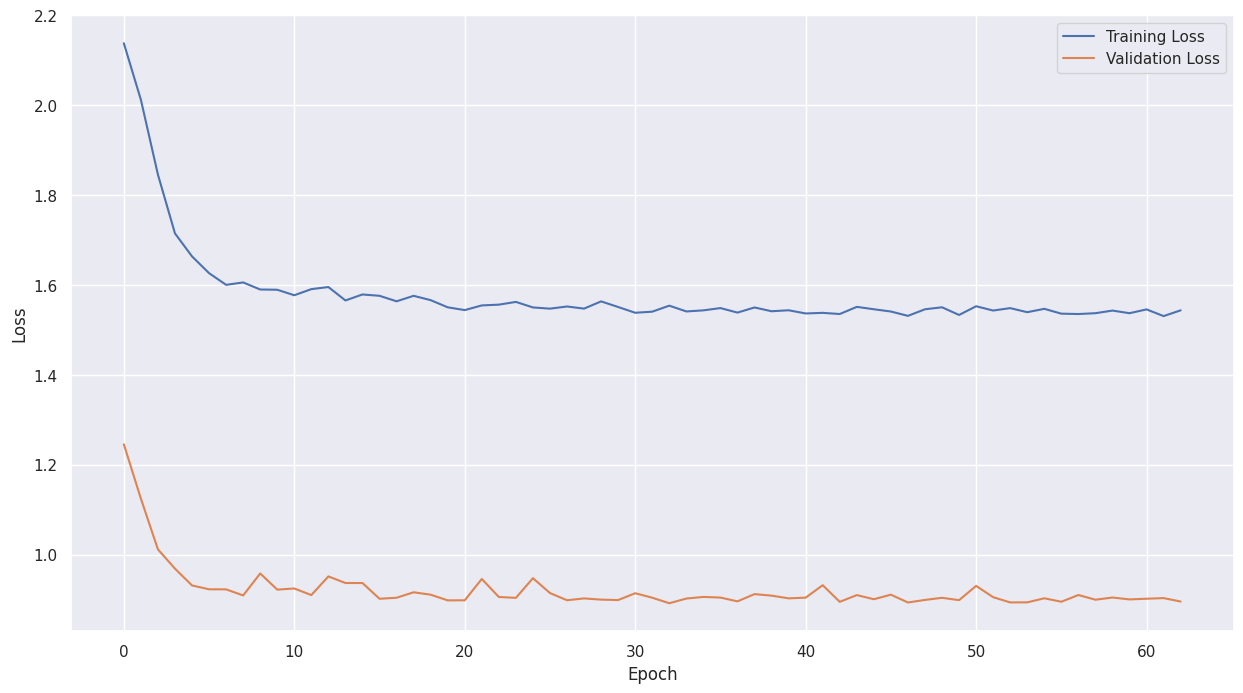

In [36]:
model_name1 = "ANN"
loss = "mean_squared_error"
optimizer = "adam"
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True)
callbacks =  ModelCheckpoint(filepath=model_name1 + ".ckpt", monitor='val_mean_squared_error', save_best_only=True)
model1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[loss])
history1 = model1.fit(X_train_processed, y_train_processed, validation_data=(X_validate_processed, y_validate_processed), epochs=200, batch_size=32, verbose = 1,  callbacks = [es, callbacks])
plt.figure(figsize=(15,8))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_mean_squared_error'], label='Validation Loss')
# Plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
predicted_stock_price_ANN_train = model1.predict(X_train_processed)
predicted_stock_price_ANN_val = model1.predict(X_validate_processed)

22/22 [==============================] - 0s 3ms/step


In [38]:
predicted_stock_price_ANN_test = model1.predict(X_test_processed)

6/6 [==============================] - 0s 3ms/step


In [39]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory ./models/ANN already exists, files will be over-written.
Model saved in directory ./models/ANN; create an archive of this directory and submit with your assignment.
Directory ./models/ANN already exists, files will be over-written.


In [40]:
y_train_processed_ANN = scaler_ytrain.inverse_transform(y_train_processed)
y_validate_processed_ANN = scaler_yval.inverse_transform(y_validate_processed)
y_test_processed_ANN = scaler_ytest.inverse_transform(y_test_processed)
predicted_stock_price_ANN_train = scaler_ytrain.inverse_transform(predicted_stock_price_ANN_train)
predicted_stock_price_ANN_val = scaler_yval.inverse_transform(predicted_stock_price_ANN_val)
predicted_stock_price_ANN_test = scaler_ytest.inverse_transform(predicted_stock_price_ANN_test)

## Error Analysis:

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Apple Stock Price Predictor - Validation data set')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Stock Price')

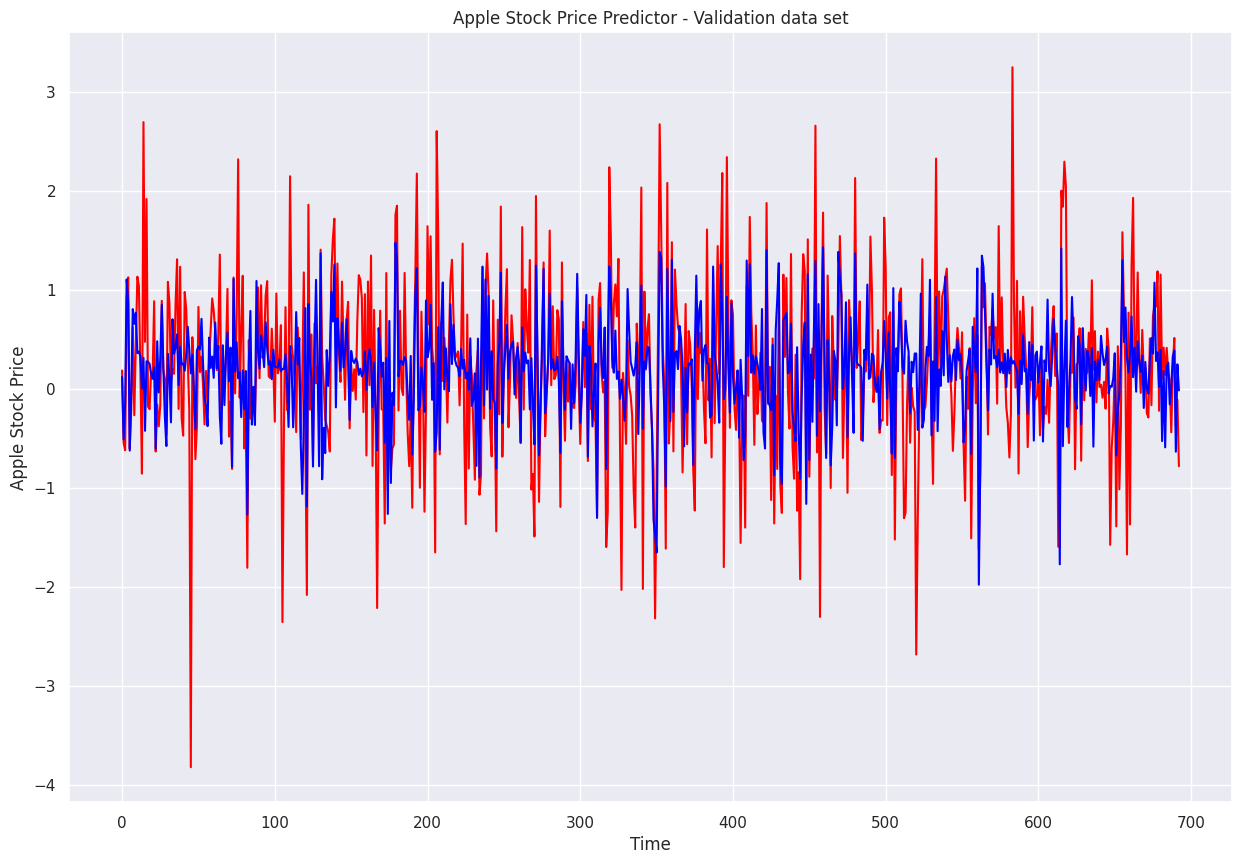

In [41]:
plt.figure(figsize=(15, 10))
plt.plot(y_validate_processed_ANN, color = 'red', label = 'Actual returns')
plt.plot(predicted_stock_price_ANN_val, color = 'blue', label = 'Predicted returns')
plt.title('Apple Stock Price Predictor - Validation data set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Apple Stock Price Predictor - Test Data Set')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Stock Price')

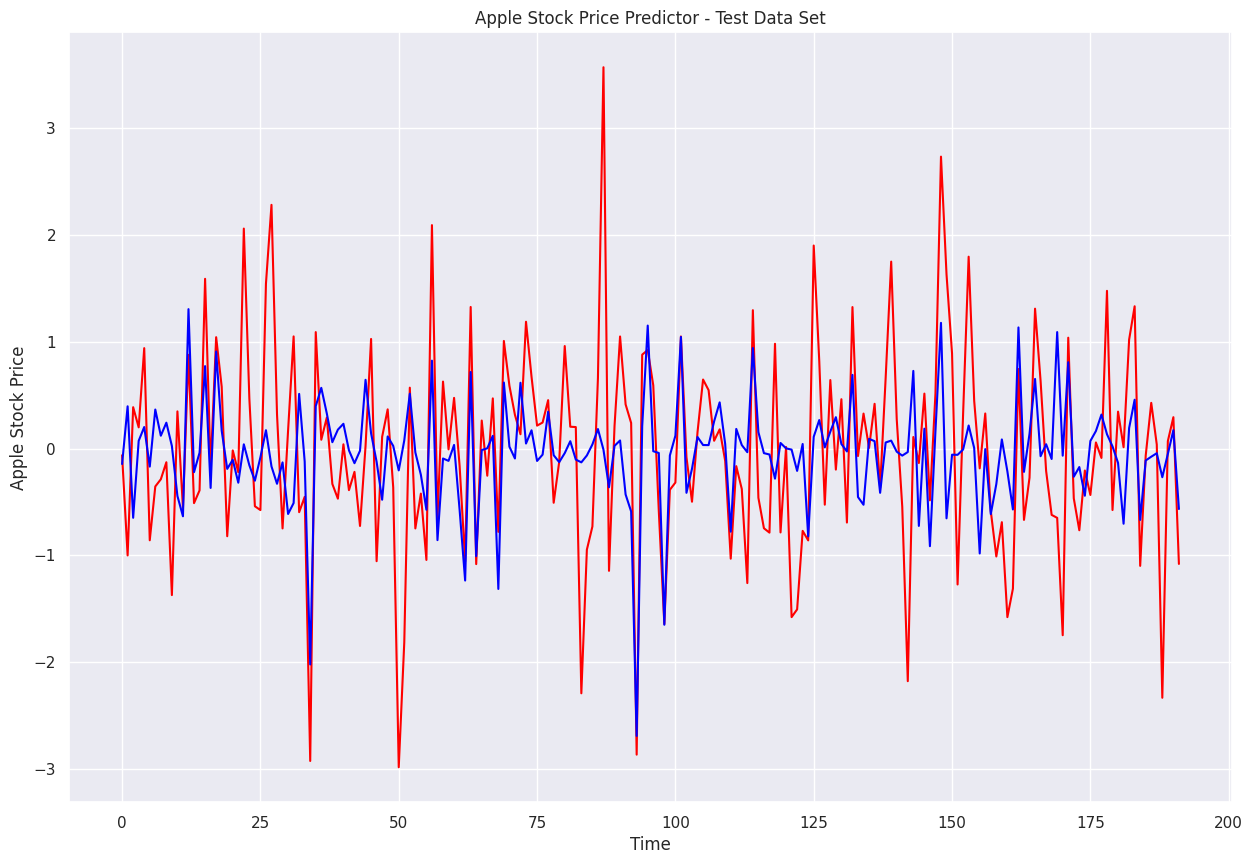

In [42]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_processed_ANN, color = 'red', label = 'Actual returns')
plt.plot(predicted_stock_price_ANN_test, color = 'blue', label = 'Predicted returns')
plt.title('Apple Stock Price Predictor - Test Data Set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')

In [43]:
mse = mean_squared_error(y_validate_processed_ANN, predicted_stock_price_ANN_val)
mae = mean_absolute_error(y_validate_processed_ANN, predicted_stock_price_ANN_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate_processed_ANN, predicted_stock_price_ANN_val)
mape = mean_absolute_percentage_error(y_validate_processed_ANN, predicted_stock_price_ANN_val)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.47937835364009335
Root Mean Squared Error (RMSE): 0.6923715430605835
Mean Absolute Error (MAE): 0.5062191355235744
R-squared (R2) score: 0.353204708425892
Mean Absolute Percentage Error (MAPE): 1.7116225471003295


In [44]:
mse = mean_squared_error(y_test_processed_ANN, predicted_stock_price_ANN_test)
mae = mean_absolute_error(y_test_processed_ANN, predicted_stock_price_ANN_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_processed_ANN, predicted_stock_price_ANN_test)
mape = mean_absolute_percentage_error(y_test_processed_ANN, predicted_stock_price_ANN_test)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.7171377406944517
Root Mean Squared Error (RMSE): 0.8468398554003299
Mean Absolute Error (MAE): 0.6380520431914557
R-squared (R2) score: 0.25007004443859127
Mean Absolute Percentage Error (MAPE): 1.7603530703576686


(array([  1.,   0.,   1.,   0.,   1.,   4.,  12.,   6.,  32.,  86., 150.,
        154., 127.,  75.,  19.,  15.,   4.,   2.,   2.,   2.]),
 array([-3.97951252, -3.62859192, -3.27767133, -2.92675074, -2.57583015,
        -2.22490956, -1.87398897, -1.52306838, -1.17214779, -0.8212272 ,
        -0.47030661, -0.11938602,  0.23153457,  0.58245517,  0.93337576,
         1.28429635,  1.63521694,  1.98613753,  2.33705812,  2.68797871,
         3.0388993 ]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'Residuals')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Residuals')

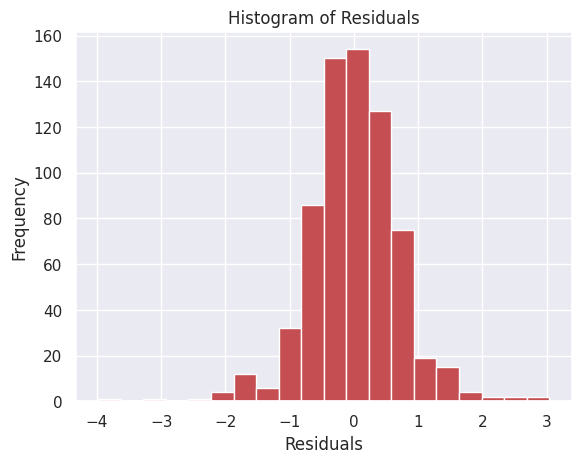

In [45]:
residuals = y_validate_processed_ANN - predicted_stock_price_ANN_val

# Plot a histogram of the residuals
plt.hist(residuals, color = 'r', bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

The residual distribution appears approximately normal indicating the model is adequately capturing the underlying patterns in the data.

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residuals vs. Predicted Values')

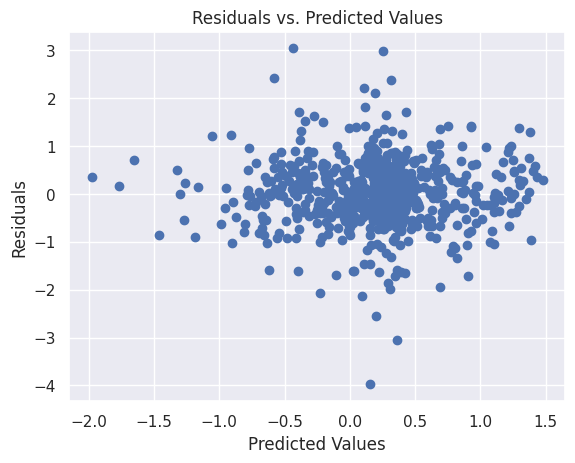

In [46]:
# Plot the residuals vs. the predicted values
plt.scatter(predicted_stock_price_ANN_val, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

The above graph shows the outliers in the predictions which are less in number as compared to the correctly predicted values indicating the model is performing well. 

## CNN Model

In [47]:
model2 = None
num_conv_features1 = 64
num_conv_features2 = 128


model2 = tf.keras.Sequential() 
model2.add(Conv1D(num_conv_features1, kernel_size=3,activation='relu', input_shape= (X_train_processed.shape[1], 1), padding="same", name = 'CNN_1'))
model2.add(Conv1D(num_conv_features1, kernel_size=3,activation='relu', padding="same", name = 'CNN_2'))
model2.add( AveragePooling1D(pool_size = 2) )
model2.add(Dropout(0.30))
model2.add(Conv1D(num_conv_features2, kernel_size=3,activation='relu', padding="same", name = 'CNN_3'))
model2.add(Conv1D(num_conv_features2, kernel_size=3,activation='relu', padding="same", name = 'CNN_4'))
model2.add( AveragePooling1D(pool_size = 2) )
model2.add(Dropout(0.30))
model2.add(tf.keras.layers.Flatten())                        
model2.add(tf.keras.layers.Dense(units = 1, activation = 'linear', name ="dense_head"))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_1 (Conv1D)              (None, 23, 64)            256       
                                                                 
 CNN_2 (Conv1D)              (None, 23, 64)            12352     
                                                                 
 average_pooling1d (AverageP  (None, 11, 64)           0         
 ooling1D)                                                       
                                                                 
 dropout_9 (Dropout)         (None, 11, 64)            0         
                                                                 
 CNN_3 (Conv1D)              (None, 11, 128)           24704     
                                                                 
 CNN_4 (Conv1D)              (None, 11, 128)           49280     
                                                      

I have used CNN 1D model over 2D model as the data is time series data and 1D CNN will work like Moving average technical indicator.

Epoch 1/200
109/109 [==============================] - ETA: 0s - loss: 2.1426 - mean_squared_error: 2.1426

109/109 [==============================] - 6s 22ms/step - loss: 2.1426 - mean_squared_error: 2.1426 - val_loss: 1.3235 - val_mean_squared_error: 1.3235
Epoch 2/200
 99/109 [==========================>...] - ETA: 0s - loss: 1.7858 - mean_squared_error: 1.7858

109/109 [==============================] - 2s 17ms/step - loss: 1.8012 - mean_squared_error: 1.8012 - val_loss: 0.9931 - val_mean_squared_error: 0.9931
Epoch 3/200
102/109 [===========================>..] - ETA: 0s - loss: 1.7216 - mean_squared_error: 1.7216

109/109 [==============================] - 2s 17ms/step - loss: 1.7080 - mean_squared_error: 1.7080 - val_loss: 0.9447 - val_mean_squared_error: 0.9447
Epoch 4/200
103/109 [===========================>..] - ETA: 0s - loss: 1.6230 - mean_squared_error: 1.6230

109/109 [==============================] - 2s 19ms/step - loss: 1.6240 - mean_squared_error: 1.6240 - val_loss: 0.9214 - val_mean_squared_error: 0.9214
Epoch 5/200
108/109 [============================>.] - ETA: 0s - loss: 1.6261 - mean_squared_error: 1.6261

109/109 [==============================] - 3s 30ms/step - loss: 1.6229 - mean_squared_error: 1.6229 - val_loss: 0.9159 - val_mean_squared_error: 0.9159
Epoch 6/200
100/109 [==========================>...] - ETA: 0s - loss: 1.6195 - mean_squared_error: 1.6195

109/109 [==============================] - 2s 17ms/step - loss: 1.6128 - mean_squared_error: 1.6128 - val_loss: 0.9077 - val_mean_squared_error: 0.9077
Epoch 7/200
109/109 [==============================] - 1s 5ms/step - loss: 1.5913 - mean_squared_error: 1.5913 - val_loss: 0.9218 - val_mean_squared_error: 0.9218
Epoch 8/200
109/109 [==============================] - 1s 5ms/step - loss: 1.5925 - mean_squared_error: 1.5925 - val_loss: 0.9164 - val_mean_squared_error: 0.9164
Epoch 9/200
109/109 [==============================] - 1s 5ms/step - loss: 1.5993 - mean_squared_error: 1.5993 - val_loss: 0.9117 - val_mean_squared_error: 0.9117
Epoch 10/200
109/109 [==============================] - 1s 5ms/step - loss: 1.5977 - mean_squared_error: 1.5977 - val_loss: 0.9399 - val_mean_squared_error: 0.9399
Epoch 11/200
107/109 [============================>.] - ETA: 0s - loss: 1.5627 - mean_squared_error: 1.5627

109/109 [==============================] - 2s 17ms/step - loss: 1.5569 - mean_squared_error: 1.5569 - val_loss: 0.9063 - val_mean_squared_error: 0.9063
Epoch 12/200
109/109 [==============================] - 1s 5ms/step - loss: 1.5697 - mean_squared_error: 1.5697 - val_loss: 0.9356 - val_mean_squared_error: 0.9356
Epoch 13/200
103/109 [===========================>..] - ETA: 0s - loss: 1.5520 - mean_squared_error: 1.5520

109/109 [==============================] - 2s 17ms/step - loss: 1.5562 - mean_squared_error: 1.5562 - val_loss: 0.9007 - val_mean_squared_error: 0.9007
Epoch 14/200
109/109 [==============================] - 1s 5ms/step - loss: 1.5477 - mean_squared_error: 1.5477 - val_loss: 0.9221 - val_mean_squared_error: 0.9221
Epoch 15/200
109/109 [==============================] - 1s 5ms/step - loss: 1.5291 - mean_squared_error: 1.5291 - val_loss: 0.9118 - val_mean_squared_error: 0.9118
Epoch 16/200
109/109 [==============================] - 1s 8ms/step - loss: 1.5258 - mean_squared_error: 1.5258 - val_loss: 0.9144 - val_mean_squared_error: 0.9144
Epoch 17/200
109/109 [==============================] - 1s 8ms/step - loss: 1.5214 - mean_squared_error: 1.5214 - val_loss: 0.9947 - val_mean_squared_error: 0.9947
Epoch 18/200
109/109 [==============================] - 1s 7ms/step - loss: 1.5129 - mean_squared_error: 1.5129 - val_loss: 0.9127 - val_mean_squared_error: 0.9127
Epoch 19/200
109/109 [======

<Figure size 1500x800 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

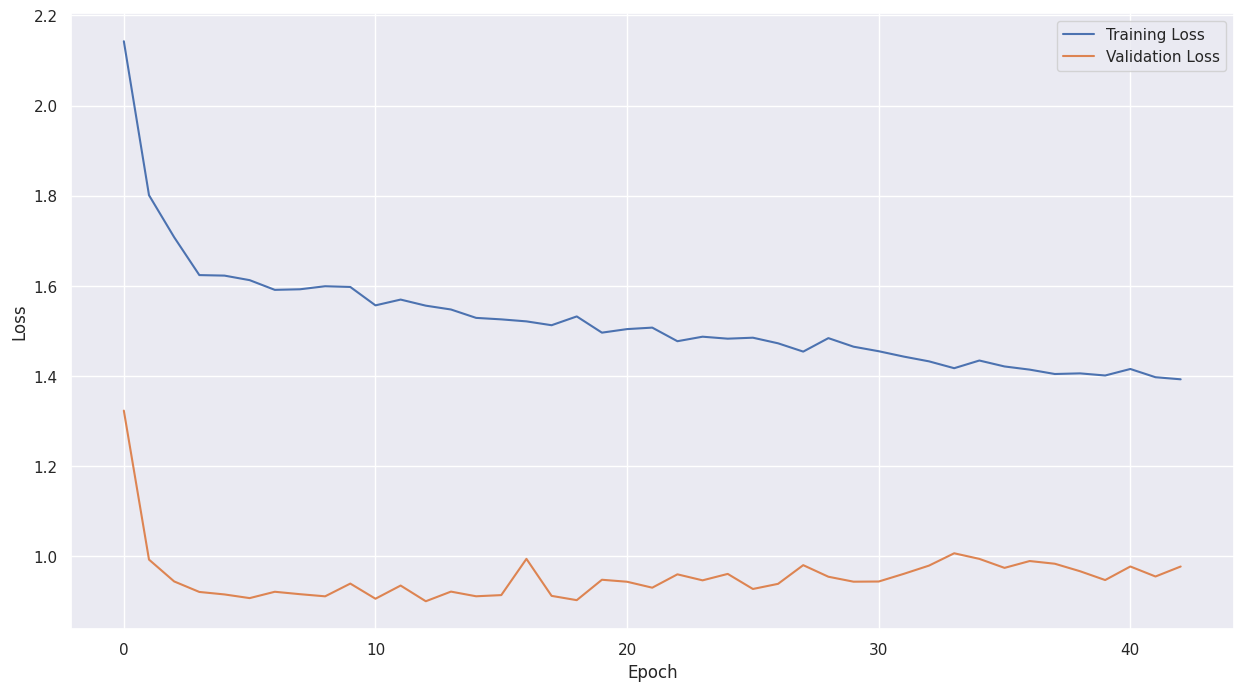

In [48]:
model_name2 = "CNN"
loss = "mean_squared_error"
optimizer = "adam"
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True)
callbacks =  ModelCheckpoint(filepath=model_name2 + ".ckpt", monitor='val_mean_squared_error', save_best_only=True)
model2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[loss])
history2 = model2.fit(X_train_processed, y_train_processed, validation_data=(X_validate_processed, y_validate_processed), epochs=200, batch_size=32, verbose = 1, callbacks = [es, callbacks])
plt.figure(figsize=(15,8))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_mean_squared_error'], label='Validation Loss')
# Plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
predicted_stock_price_CNN_train = model1.predict(X_train_processed)
predicted_stock_price_CNN_val = model1.predict(X_validate_processed)

22/22 [==============================] - 0s 3ms/step


In [50]:
predicted_stock_price_CNN_test = model2.predict(X_test_processed)

6/6 [==============================] - 0s 3ms/step


In [51]:
helper.saveModel(model2, model_name2)
helper.saveHistory(history2, model_name2)

Directory ./models/CNN already exists, files will be over-written.
Model saved in directory ./models/CNN; create an archive of this directory and submit with your assignment.
Directory ./models/CNN already exists, files will be over-written.


In [52]:
y_train_processed_CNN = scaler_ytrain.inverse_transform(y_train_processed)
y_validate_processed_CNN = scaler_yval.inverse_transform(y_validate_processed)
y_test_processed_CNN = scaler_ytest.inverse_transform(y_test_processed)
predicted_stock_price_CNN_train = scaler_ytrain.inverse_transform(predicted_stock_price_CNN_train)
predicted_stock_price_CNN_val = scaler_yval.inverse_transform(predicted_stock_price_CNN_val)
predicted_stock_price_CNN_test = scaler_ytest.inverse_transform(predicted_stock_price_CNN_test)

## Error Analysis:

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Apple Stock Price Predictor')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Stock Price')

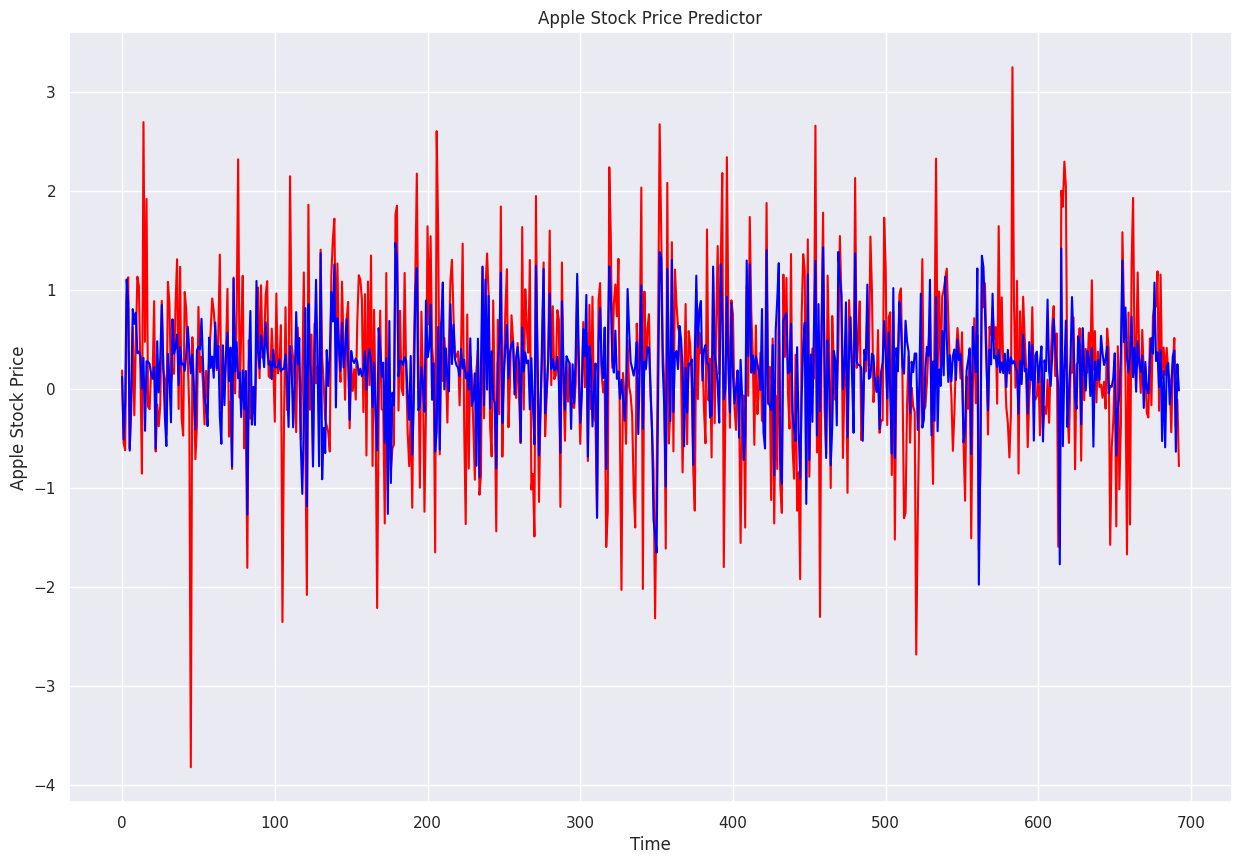

In [53]:
plt.figure(figsize=(15, 10))
plt.plot(y_validate_processed_CNN, color = 'red', label = 'Actual returns')
plt.plot(predicted_stock_price_CNN_val, color = 'blue', label = 'Predicted returns')
plt.title('Apple Stock Price Predictor')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Apple Stock Price Predictor')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Stock Price')

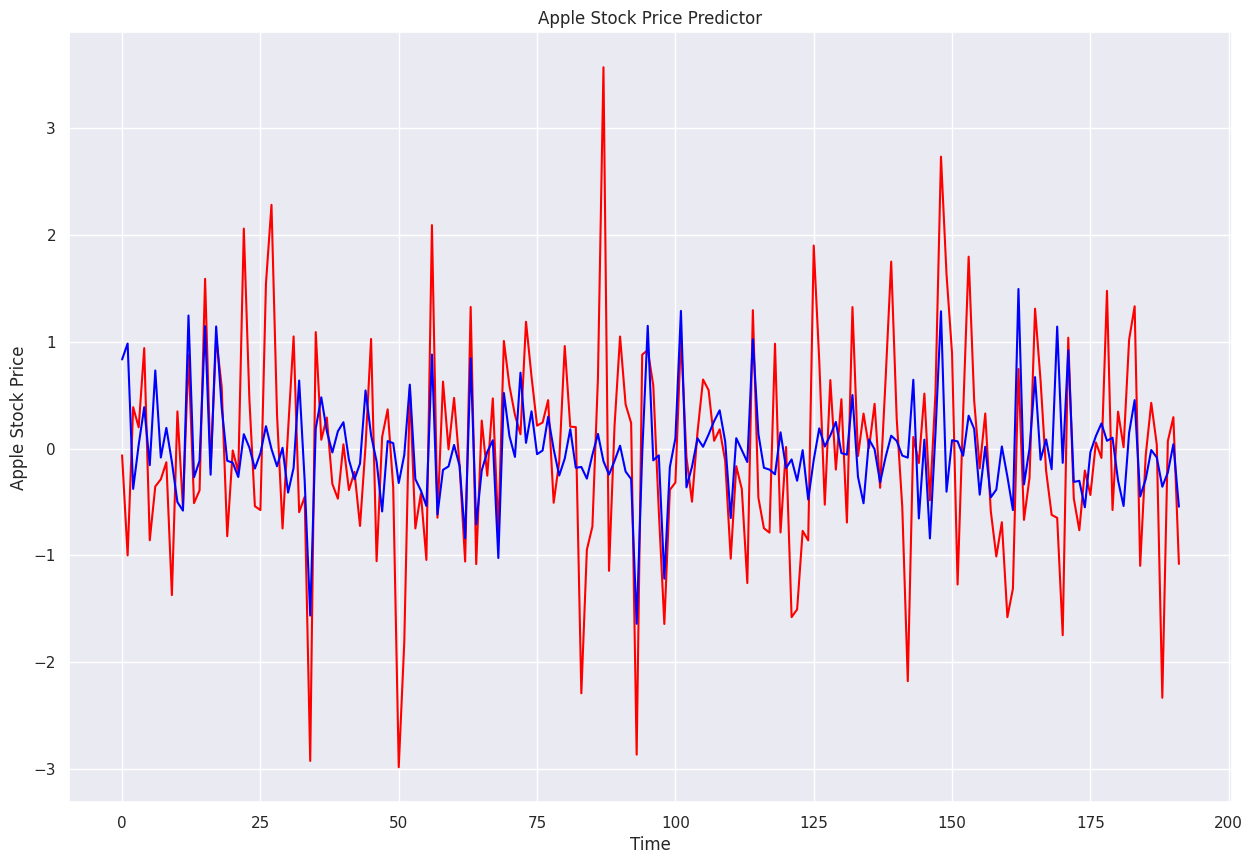

In [54]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_processed_CNN, color = 'red', label = 'Actual returns')
plt.plot(predicted_stock_price_CNN_test, color = 'blue', label = 'Predicted returns')
plt.title('Apple Stock Price Predictor')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')

In [55]:
mse = mean_squared_error(y_validate_processed_CNN, predicted_stock_price_CNN_val)
mae = mean_absolute_error(y_validate_processed_CNN, predicted_stock_price_CNN_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate_processed_CNN, predicted_stock_price_CNN_val)
mape = mean_absolute_percentage_error(y_validate_processed_CNN, predicted_stock_price_CNN_val)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.47937835364009335
Root Mean Squared Error (RMSE): 0.6923715430605835
Mean Absolute Error (MAE): 0.5062191355235744
R-squared (R2) score: 0.353204708425892
Mean Absolute Percentage Error (MAPE): 1.7116225471003295


In [56]:
mse = mean_squared_error(y_test_processed_CNN, predicted_stock_price_CNN_test)
mae = mean_absolute_error(y_test_processed_CNN, predicted_stock_price_CNN_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_processed_CNN, predicted_stock_price_CNN_test)
mape = mean_absolute_percentage_error(y_test_processed_CNN, predicted_stock_price_CNN_test)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.7070780772827464
Root Mean Squared Error (RMSE): 0.8408793476371901
Mean Absolute Error (MAE): 0.6342644153289643
R-squared (R2) score: 0.26058970127327064
Mean Absolute Percentage Error (MAPE): 1.7907258147587808


(array([  1.,   0.,   1.,   0.,   1.,   4.,  12.,   6.,  32.,  86., 150.,
        154., 127.,  75.,  19.,  15.,   4.,   2.,   2.,   2.]),
 array([-3.97951252, -3.62859192, -3.27767133, -2.92675074, -2.57583015,
        -2.22490956, -1.87398897, -1.52306838, -1.17214779, -0.8212272 ,
        -0.47030661, -0.11938602,  0.23153457,  0.58245517,  0.93337576,
         1.28429635,  1.63521694,  1.98613753,  2.33705812,  2.68797871,
         3.0388993 ]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'Residuals')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Residuals')

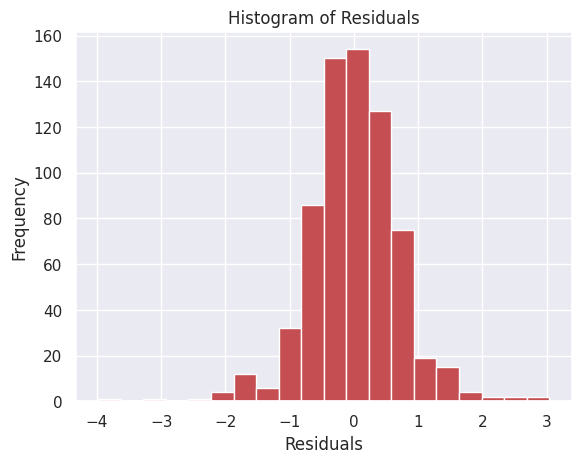

In [57]:
residuals = y_validate_processed_CNN - predicted_stock_price_CNN_val

# Plot a histogram of the residuals
plt.hist(residuals, color = 'r', bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residuals vs. Predicted Values')

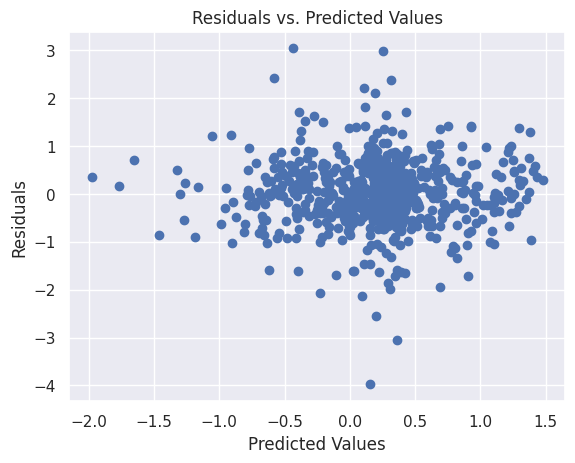

In [58]:
# Plot the residuals vs. the predicted values
plt.scatter(predicted_stock_price_CNN_val, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

In [64]:
model_loaded = helper.loadModel(model_name2)

In [65]:
import os
from tensorflow.keras.models import load_model
from datetime import datetime

#modelName = "final_model"
modelName = "CNN"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, test_dir1, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    dateAttr = "Dt"
    # # YOUR CODE GOES HERE
    data = pd.read_csv(test_dir,index_col = dateAttr)
    data1 = pd.read_csv(test_dir1, index_col = dateAttr)
    ids = data.index
    X_test_processed, y_test_processed, scaler_xtest, scaler_ytest = Normalization_Split_test(data, data1)
    predictions = model.predict(X_test_processed)
    y_test_processed_model = scaler_ytest.inverse_transform(y_test_processed)
    predictions = scaler_ytest.inverse_transform(predictions)
    plot(y_test_processed_model, predictions)

    
    return predictions, ids
    

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model_loaded  # CHANGE None to your model !
saveModel(my_model, model_path)

Directory ./CNN already exists, files will be over-written.
Model saved in directory ./CNN; create an archive of this directory and submit with your assignment.


## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will copy your model file to this directory with the name stored in `model_path`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [66]:
# holdout_dir = os.path.join(".", "Data", "holdout")
# predicts = MyModel(holdout_dir, model_path)

6/6 [==============================] - 0s 3ms/step


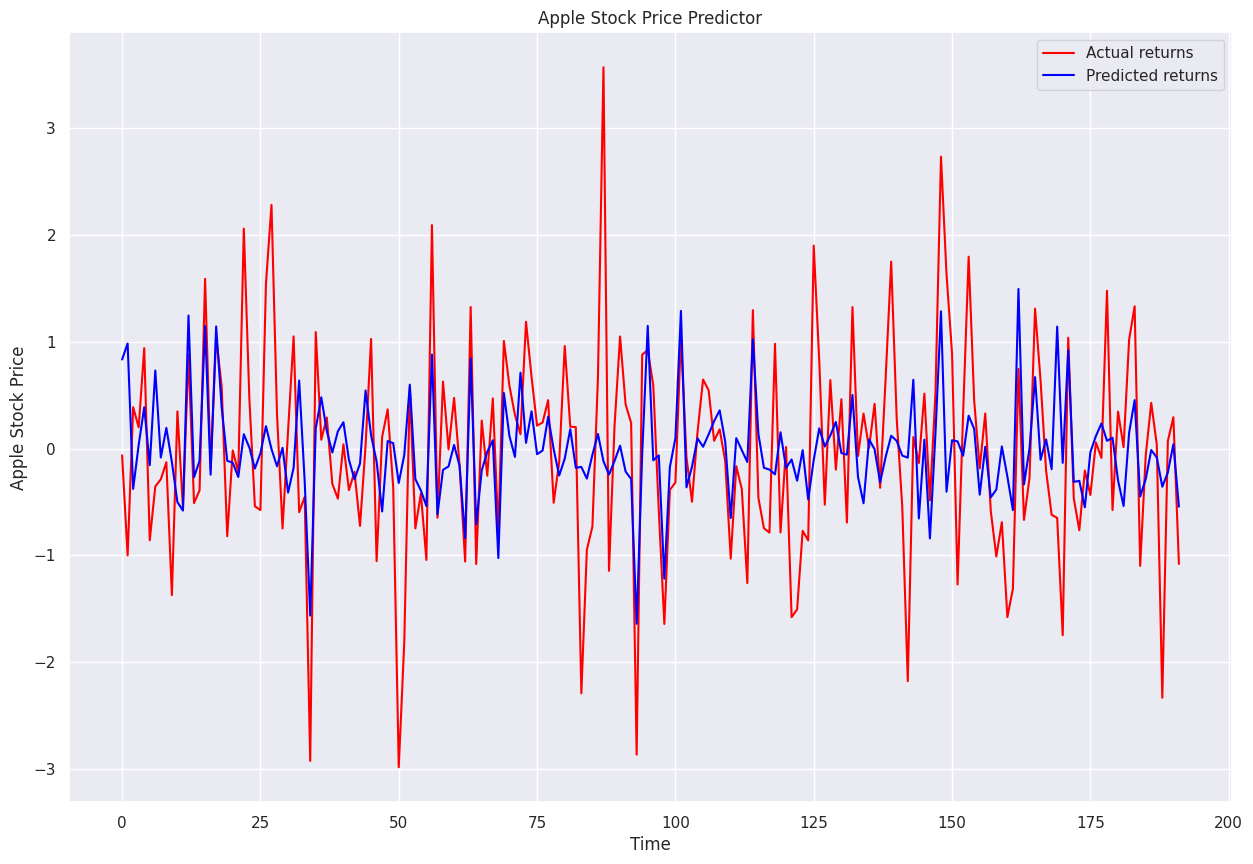

In [67]:
# need to give two files: AAPL and SPY as I have used both of them to train my model, replace 'sample' with 'holdout'
holdout_dir = os.path.join(".", "Data", "sample", "AAPL.csv")
holdout_dir1 = os.path.join(".","Data","sample", "SPY.csv")
predicts, ids = MyModel(holdout_dir, holdout_dir1, model_path)

I chosen CNN model as the best performing model as I got lesser Mean-Squared Error, Root Mean Squared Error, Mean Absolute error, Mean Absolute Percentage error and high R-Squared score as compared to the other models on the test data set that I created.

## Conclusion

Upon reviewing the test results, it appears that the error and r2 score on the test set are not as impressive as what was observed during training, even though measures were taken to prevent overfitting. These findings suggest that despite the use of sophisticated tools such as Deep learning models, it remains challenging to accurately predict stock market prices/returns solely based on historical prices. While incorporating financial data may improve the prediction process, I am skeptical that it would be a valuable investment of our time to rely solely on deep learning for stock market prediction.


While there have been some successes in this area, it remains a challenging task due to the inherent complexity and volatility of the stock market. On the other hand, the use of deep learning for portfolio management through a reinforcement learning framework is a promising area of research that has gained traction in recent years. By incorporating deep learning techniques, such as neural networks and deep reinforcement learning, into the management of investment portfolios, it may be possible to optimize investment decisions and achieve better long-term performance.

In [63]:
print("Done")

Done
